In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn. metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import pickle
from datetime import date
from patsy import dmatrices
import statsmodels.api as sm
from collections import defaultdict
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#import calender
from matplotlib.ticker import MaxNLocator

import jenkspy
Writer = animation.writers['pillow']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
af_to_104m3 = 0.123348

In [4]:
def DailyMean( maindf, month, yrs, days, monthnumber, inputyr):

    Daylist = defaultdict(list)
    DayFrame= defaultdict(list)
    timecol = ['Year', 'Month' , 'Day']

    for i in days:
        Daylist[month+ str(i)]= []
        DayFrame[month + str(i)] = pd.DataFrame(yrs, columns=['Year'])
    

    for i in yrs:
        for j in days:
            Daylist[month+str(j)].append(maindf.loc[str(i)+'-'+ monthnumber +'-'+str(j)]['SLCDPU_DC_Water_Use'])
            DayFrame[month+str(j)]['Day']=j
            DayFrame[month+str(j)]['Month'] = int(monthnumber)

    for i in DayFrame:
        DayFrame[i]['Daily_DC_Delivery'] = Daylist[i]
        
    for i in DayFrame:
        DayFrame[i]['Hist_Mean_DC_Delivery']= np.mean(DayFrame[i]['Daily_DC_Delivery'])
        del DayFrame[i]['Daily_DC_Delivery']
        
        ##put into year of choice
        DayFrame[i]['Year']=inputyr
        #create the date for input into figure DF
        DayFrame[i].insert(loc=0, column='Date', value=pd.to_datetime(DayFrame[i][['Year', 'Month', 'Day']]))
        DayFrame[i] = DayFrame[i].drop(columns = timecol)
        DayFrame[i]=DayFrame[i].set_index('Date')
        DayFrame[i]=DayFrame[i].iloc[0]
        DayFrame[i] = pd.DataFrame(DayFrame[i]).T
        
        
    return DayFrame

In [5]:
#Make a function to do all of the below for me so evaluate scenarios much quicker/easier


def ForecastDataPrep(DFin, DF0cons, Outyear, DellDF, simulation):
    af_to_104m3 = 0.123348
    
    #set the index to time
    DFin=DFin.set_index('Time')
    DellDF=DellDF.set_index('Time')
    
    #Use historical data, prior to WY2021
    Histyrs=DF0cons.copy()
    Histyrs=Histyrs.set_index('Time')
    Histyrs = Histyrs[:"2020-10-31"]
    
    #add info to Dell reservoir deadpool
    DellDF['Mtn_Deadpool'] = 800
    DellDF['Little_Deadpool'] = 1000
    
    #Select time of importance 2021, 2022
    DFin = DFin[DFin.index.year.isin([Outyear])].copy()
    Dell = DellDF[DellDF.index.year.isin([Outyear])].copy()
    
    #remove WY months not in WY
    #DFin = DFin[~DFin.index.month.isin([10,11,12])]
    
    #remove months that are not if interst in historical dataset
    Histyrs = Histyrs[~Histyrs.index.month.isin([1,2,3,11,12])]
    
    #convert daily outputs (AF) to 104m3
    for i in DFin:       
        DFin[i]=DFin[i]*af_to_104m3
        Histyrs[i]=Histyrs[i]*af_to_104m3
    '''
    Using the historical daily DC water usage, Find the mean daily DC usage and add it to the 
    Main DF to compare 2021 and 2022 water usage.
    '''
    yrs = np.arange(2001,2021,1)
    Aprdays = np.arange(1,31,1)
    Maydays = np.arange(1,32,1)
    Jundays = np.arange(1,31,1)
    Juldays = np.arange(1,32,1)
    Augdays = np.arange(1,32,1)
    Sepdays = np.arange(1,31,1)
    Octdays = np.arange(1,32,1)

    #Set up DF for mean daily DC water usage for WY 2021
    Apr = DailyMean(Histyrs,'Apr', yrs, Aprdays, '04', Outyear)
    May = DailyMean(Histyrs,'May', yrs, Maydays, '05', Outyear)
    Jun = DailyMean(Histyrs,'Jun', yrs, Jundays, '06', Outyear)
    Jul = DailyMean(Histyrs,'Jul', yrs, Juldays, '07', Outyear)
    Aug = DailyMean(Histyrs,'Aug', yrs, Augdays, '08', Outyear)
    Sep = DailyMean(Histyrs,'Sep', yrs, Sepdays, '09', Outyear)
    Oct = DailyMean(Histyrs,'Oct', yrs, Octdays, '10', Outyear)

    DC_Mean = pd.DataFrame()
    for i in Apr:
        DC_Mean = DC_Mean.append(Apr[i])
    for i in May:
        DC_Mean = DC_Mean.append(May[i])
    for i in Jun:
        DC_Mean = DC_Mean.append(Jun[i])
    for i in Jul:
        DC_Mean = DC_Mean.append(Jul[i])
    for i in Aug:
        DC_Mean = DC_Mean.append(Aug[i])
    for i in Sep:
        DC_Mean = DC_Mean.append(Sep[i])
    for i in Oct:
        DC_Mean = DC_Mean.append(Oct[i])
    
    #create an empty column for mean delivery
    DFin['Hist_Mean_DC_Delivery'] = 0

    #Update the Output2021 with historical period daily DC usage
    DFin.update(DC_Mean)
    
    DFin['Extra_DC'] = DFin['SLCDPU_DC_Water_Use']-DFin['Hist_Mean_DC_Delivery']

    #Make negative values zero for simplicity
    DFin.loc[DFin['Extra_DC'] < 0, ['Extra_DC']] = 0
    
    #del DFin['Unnamed: 6']
    #create a DF for monthly sum of Outputs
    DFinMonthly =DFin.copy()
    HistyrsMonthly = Histyrs.copy()

    #Take the monthly sum
    DFinMonthly = DFinMonthly.resample('M').sum()
    HistyrsMonthly = HistyrsMonthly.resample('M').sum()


    #convert this one to acre feet, no need it all units are m3
   # for i in DFinMonthly:
    #    DFinMonthly[i] = DFinMonthly[i]*(1/0.2713280731353764)
        
    #for i in HistyrsMonthly:
     #   HistyrsMonthly[i] = HistyrsMonthly[i]*(1/0.2713280731353764)

    
    return DFin, DFinMonthly, Dell


In [6]:
def Sup_Dem_Figure2(DayDF, MonthDF, Dell, yr, IndoorCons, OutdoorCons, FigPath, simulation, modeltype):
    
    #need to convert MGD to m3x10^4
    #DayDF = DayDF*0.454609
   
    #need to convert Acre-Feet to 10^4m3
    #MonthDF = MonthDF*0.123348
    
    MonthDF['Month'] = MonthDF.index
    MonthDF['Month'] = pd.to_datetime(MonthDF['Month'], format='%m').dt.month_name().str.slice(stop=3)
    MonthDF.index = MonthDF['Month']
    del MonthDF['Month']
    
    simulation.split()[0]
    simulation = simulation.split()
    if simulation[0] == 'Surplus':
        replacement = 'Wet'
    if simulation[0] == 'Drought':
        replacement = 'Dry'
    if simulation[0] == 'Average':
        replacement = 'Average'

    simulation[0] = replacement
    str1 = " " 

    simulation = str1.join(simulation)
    
    labelsize = 15
    linewidth = 2
 
    #Reduce width to increase space between bars
    width = 1
    widthM = .95

    fig, ax = plt.subplots(2,1, constrained_layout=True)
    fig.set_size_inches(7,9)
    DayDF['ExtraDC'] = DayDF.SLCDPU_DC_Water_Use-DayDF.Hist_Mean_DC_Delivery
    
    #Daily Figure
    ax[0].bar(DayDF.index, DayDF.SLCDPU_Prod_Demands, width=width, 
        color='blue', label='Sim: '+ simulation)
    ax[0].bar(DayDF.index, DayDF.SLCDPU_DC_Water_Use, width=width, 
        color='r', label=  'Modeled Deer Creek Request')
    ax[0].plot(DayDF.index, DayDF.Hist_Mean_DC_Delivery, linewidth = linewidth,
        color='purple', label='Hist. Mean Deer Creek Request')
    ax[0].set_ylim(0,105)
  #  ax[0].set_xlim(737772.25+60, 738173.75-60)
    ax[0].annotate('A.', xy=(DayDF.index[308], 110), size = labelsize+2)
    ax[0].legend(loc = 'upper left', fontsize = labelsize)
    ax[0].set_ylabel('Daily System Demand ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[0].tick_params(axis = 'both', labelsize = labelsize-4 )
   

    #Monthly Figure
   # df['Month'] = pd.to_datetime(df['Month'], format='%m').dt.month_name().str.slice(stop=3)

    ax[1].bar(MonthDF.index, MonthDF.SLCDPU_Prod_Demands, width=widthM, 
        color='blue', label=modeltype)
    ax[1].bar(MonthDF.index, MonthDF.SLCDPU_DC_Water_Use, width=widthM, 
        color='red', label='Deer Creek Reservoir Usage')
    ax[1].hlines(MonthDF.Hist_Mean_DC_Delivery.iloc[4], 3.5, 4.5, linewidth = linewidth, linestyle='-', color='purple')
    ax[1].hlines(MonthDF.Hist_Mean_DC_Delivery.iloc[5], 4.5, 5.5, linewidth = linewidth, linestyle='-', color='purple')
    ax[1].hlines(MonthDF.Hist_Mean_DC_Delivery.iloc[6], 5.5, 6.5, linewidth = linewidth, linestyle='-', color='purple')
    ax[1].hlines(MonthDF.Hist_Mean_DC_Delivery.iloc[7], 6.5, 7.5, linewidth = linewidth, linestyle='-', color='purple')
    ax[1].hlines(MonthDF.Hist_Mean_DC_Delivery.iloc[8], 7.5, 8.5, linewidth = linewidth, linestyle='-', color='purple')
    ax[1].hlines(MonthDF.Hist_Mean_DC_Delivery.iloc[9], 8.5, 9.5, linewidth = linewidth, linestyle='-', color='purple')
    ax[1].set_ylim(0,2400)
  #  ax[1].set_xlim(1.5, 10.5)
   # x_min, x_max = ax[1].get_xlim()
    ax[1].annotate('B.', xy=(10.1, 2800),size = labelsize+2)
    ax[1].set_ylabel('Monthly System Demands ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[1].set_xlabel('Time', size = labelsize)
    ax[1].tick_params(axis = 'both', labelsize = labelsize-2)
    #Save Figure
    #fig.savefig(FigPath+str(yr)+simulation+'.pdf')
    fig.savefig(FigPath+str(yr)+simulation+'.png', dpi = 300)



In [21]:
def Sup_Dem_Figure_Err_CSD(Day, Month, DayL, MonthL, DayH, MonthH,DayO, MonthO,
                       yr, IndoorCons, OutdoorCons, FigPath, simulation, modeltype):
    
    #need to convert MGD to m3x10^4
    #DayDF = DayDF*0.454609
   
    #need to convert Acre-Feet to 10^4m3
    #MonthDF = MonthDF*0.123348
    
    #Copy dfs 
    DayDF = Day.copy()
    MonthDF = Month.copy()
    
    DayDFL = DayL.copy()
    MonthDFL = MonthL.copy()
    
    DayDFH = DayH.copy()
    MonthDFH = MonthH.copy()
    
    DayDFO = DayO.copy()
    MonthDFO = MonthO.copy()
    
    #Set up a daily DF for DC water use
    PredD = pd.DataFrame()
    PredD['Low'] = DayDFL['SLCDPU_DC_Water_Use']
    PredD['Mean'] = DayDF['SLCDPU_DC_Water_Use']
    PredD['High'] = DayDFH['SLCDPU_DC_Water_Use']
    PredD['Obs'] = DayDFO['SLCDPU_DC_Water_Use']
    
    #Define Error bars for visualization
    PredD['UErr'] = PredD['High'] - PredD['Mean']
    PredD['LErr'] = PredD['Mean'] - PredD['Low']

    asymmetric_errorD = [PredD['LErr'], PredD['UErr'] ]
    
    #Set up a Monthly DF for DC water use
    PredM = pd.DataFrame()
    PredM['Low'] = MonthDFL['SLCDPU_DC_Water_Use']
    PredM['Mean'] = MonthDF['SLCDPU_DC_Water_Use']
    PredM['High'] = MonthDFH['SLCDPU_DC_Water_Use']
    PredM['Obs'] = MonthDFO['SLCDPU_DC_Water_Use']
    
    #Define Error bars for visualization
    PredM['UErr'] = PredM['High'] - PredM['Mean']
    PredM['LErr'] = PredM['Mean'] - PredM['Low']
    PredM['LErr'] = [0 if x < 0 else x for x in PredM['LErr']]
    asymmetric_errorM = [PredM['LErr'], PredM['UErr'] ]
    
     #Set up a Monthly DF for Demand water use
    Pred_DM = pd.DataFrame()
    Pred_DM['Low'] = MonthDFL['SLCDPU_Prod_Demands']
    Pred_DM['Mean'] = MonthDF['SLCDPU_Prod_Demands']
    Pred_DM['High'] = MonthDFH['SLCDPU_Prod_Demands']
    Pred_DM['Obs'] = MonthDFO['SLCDPU_Prod_Demands']
    

    #Define Error bars for visualization
    Pred_DM['UErr'] = Pred_DM['High'] - Pred_DM['Mean']
    Pred_DM['LErr'] = Pred_DM['Mean'] - Pred_DM['Low']

    asymmetric_errorDemM = [Pred_DM['LErr'], Pred_DM['UErr'] ]

    
    MonthDF['Month'] = MonthDF.index
    MonthDF['Month'] = pd.to_datetime(MonthDF['Month'], format='%m').dt.month_name().str.slice(stop=3)
    MonthDF.index = MonthDF['Month']
    del MonthDF['Month']
    
   
    MonthDFO.index = MonthDF.index
    
    
    
    simulation.split()[0]
    simulation = simulation.split()
    if simulation[0] == 'Surplus':
        replacement = 'Wet'
    if simulation[0] == 'Drought':
        replacement = 'Dry'
    if simulation[0] == 'Average':
        replacement = 'Average'

    simulation[0] = replacement
    str1 = " " 

    simulation = str1.join(simulation)
    
    labelsize = 12
    linewidth = 2
 
    #Reduce width to increase space between bars
    width = 1
    widthM = .95

    fig, ax = plt.subplots(3,2, constrained_layout=True, gridspec_kw={'width_ratios': [3, 1]})
    fig.set_size_inches(11,7)
    DayDF['ExtraDC'] = DayDF.SLCDPU_DC_Water_Use-DayDF.Hist_Mean_DC_Delivery
    
    #Daily Figure
    #Demand Variability
    ax[0,0].plot(DayDF.index, DayDF.SLCDPU_Prod_Demands, linewidth = linewidth, 
        color='blue', label='Sim: '+ simulation)
    ax[0,0].fill_between(DayDF.index, DayDFL.SLCDPU_Prod_Demands, DayDFH.SLCDPU_Prod_Demands, 
        color='steelblue')
    ax[0,0].plot(DayDFO.index, DayDFO.SLCDPU_Prod_Demands, linewidth = linewidth, 
        color='slategrey', label = 'Observed Demands')
    #Deer Creek Variability  
    ax[0,0].plot(DayDF.index, DayDF.SLCDPU_DC_Water_Use, linewidth = linewidth,
        color='r', label=  'Modeled Deer Creek Request')
    ax[0,0].fill_between(DayDF.index, DayDFL.SLCDPU_DC_Water_Use, DayDFH.SLCDPU_DC_Water_Use, 
        color='coral')
    #Observed Deer Creek use
    ax[0,0].plot(DayDFO.index, DayDFO.SLCDPU_DC_Water_Use, color='maroon',
                    label=  'Observed Deer Creek Request', linewidth = linewidth-1)
    
    ax[0,0].plot(DayDF.index, DayDF.Hist_Mean_DC_Delivery, linewidth = linewidth,
        color='purple', label='Hist. Mean Deer Creek Request')
    ax[0,0].set_ylim(0,105)
  #  ax[0].set_xlim(737772.25+60, 738173.75-60)
    ax[0,0].annotate('A.', xy=(DayDF.index[15], 92), size = labelsize+2)
    ax[0,0].set_ylabel('Daily ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[0,0].tick_params(axis = 'both', labelsize = labelsize-4 )
    ax[0,0].margins(0)
    
    
    #Observed vs predicted Deer Dreek Daily use
    ax[0,1].errorbar(PredD.Obs, PredD.Mean, yerr = asymmetric_errorD, fmt='.k', ecolor = 'coral', mec = 'red') 
    ax[0,1].plot([0, 30], [0, 30], ls="--", c=".3")
    ax[0,1].set_ylabel('Predicted ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[0,1].set_xticks(np.arange(0, 31, 10))
    ax[0,1].set_yticks(np.arange(0, 45, 10))
    ax[0,1].set_ylim(0,45)
    ax[0,1].annotate('B.', xy=(1, 40),size = labelsize+2)
    ax[0,1].margins(0)
    
   

    #Monthly Demands
    ax[1,0].bar(MonthDF.index, MonthDF.SLCDPU_Prod_Demands,align = 'edge', width=-widthM/2, 
        color='blue', label=modeltype, yerr = asymmetric_errorDemM, capsize = 4)
    ax[1,0].bar(MonthDFO.index, MonthDFO.SLCDPU_Prod_Demands, align = 'edge', width=widthM/2, 
        color='slategrey', label='Observed Demands')
    ax[1,0].set_ylabel('Monthly ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[1,0].set_xlabel('Time', size = labelsize)
    ax[1,0].tick_params(axis = 'both', labelsize = labelsize-2)
    ax[1,0].set_ylim(0,2500)
    ax[1,0].annotate('C.', xy=(MonthDF.index[0], 2200),size = labelsize+2)
    ax[1,0].margins(0)
    
    
    #Observed vs predicted Monthly Demand use
    ax[1,1].errorbar(Pred_DM.Obs, Pred_DM.Mean, yerr = asymmetric_errorDemM, fmt='.k', ecolor = 'steelblue', mec = 'blue') 
    ax[1,1].plot([0, 2500], [0, 2500], ls="--", c=".3")
    ax[1,1].set_ylabel('Predicted ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[1,1].set_xticks(np.arange(0, 2501, 500))
    ax[1,1].set_yticks(np.arange(0, 2501, 500))
    ax[1,1].set_ylim(0,2500)
    ax[1,1].annotate('D.', xy=(40, 2200),size = labelsize+2)
    ax[1,1].margins(0)
   
    
    #Monthly DC
    ax[2,0].bar(MonthDF.index, MonthDF.SLCDPU_DC_Water_Use,align = 'edge', width=-widthM/2, 
        color='red', label=modeltype, yerr = asymmetric_errorM, capsize = 4)
    ax[2,0].bar(MonthDFO.index, MonthDFO.SLCDPU_DC_Water_Use, align = 'edge', width=widthM/2, 
        color='maroon', label='Observed Demands')
    ax[2,0].annotate('B.', xy=(10.1, 2800),size = labelsize+2)
    ax[2,0].set_ylabel('Monthly ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[2,0].set_xlabel('Time', size = labelsize)
    ax[2,0].tick_params(axis = 'both', labelsize = labelsize-2)
    ax[2,0].set_ylim(0,1300)
    ax[2,0].annotate('E.', xy=(MonthDF.index[0], 1150),size = labelsize+2)
    ax[2,0].margins(0)
    
    
     #Observed vs predicted Deer Creek use
    ax[2,1].errorbar(PredM.Obs, PredM.Mean, yerr = asymmetric_errorM, fmt='.k', ecolor = 'coral', mec = 'red') 
    ax[2,1].plot([0, 1300], [0, 1300], ls="--", c=".3")
    ax[2,1].set_ylabel('Predicted ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[2,1].set_xlabel('Observed ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[2,1].set_xticks(np.arange(0, 1301, 250))
    ax[2,1].set_yticks(np.arange(0, 1301, 250))
    ax[2,1].set_ylim(0,1300)
    ax[2,1].annotate('F.', xy=(20, 1150),size = labelsize+2)
    ax[2,1].margins(0)
    
    #Save Figure
    #fig.savefig(FigPath+str(yr)+simulation+'.pdf')
    plt.subplots_adjust(right=1)
    handles, labels = ax[0,0].get_legend_handles_labels()
    lgd = ax[0,0].legend(handles, labels, loc = 'upper left', fontsize = labelsize, ncol = 2, bbox_to_anchor=(.1, 1.7))
    text = ax[0,0].text(-0.0,1.05, " ", transform=ax[0,0].transAxes)
    
    fig.savefig(FigPath+str(yr)+simulation+'.pdf',bbox_extra_artists=(lgd,text), bbox_inches='tight', dpi = 300)



In [8]:
def Sup_Dem_Figure_Err_Trad(Day, Month, DayO, MonthO, yr, IndoorCons, OutdoorCons, FigPath, simulation, modeltype):
    
    #need to convert MGD to m3x10^4
    #DayDF = DayDF*0.454609
   
    #need to convert Acre-Feet to 10^4m3
    #MonthDF = MonthDF*0.123348
    
    #Copy dfs 
    DayDF = Day.copy()
    MonthDF = Month.copy()
    
    DayDFO = DayO.copy()
    MonthDFO = MonthO.copy()
    
    #Set up a daily DF for DC water use
    PredD = pd.DataFrame()
    PredD['Low'] = DayDF['SLCDPU_DC_Water_Use']*.9
    PredD['Mean'] = DayDF['SLCDPU_DC_Water_Use']
    PredD['High'] = DayDF['SLCDPU_DC_Water_Use']*1.1
    PredD['Obs'] = DayDFO['SLCDPU_DC_Water_Use']
    PredD.index = DayDF.index
    
    PredDD = pd.DataFrame()
    PredDD['Low'] = DayDF['SLCDPU_Prod_Demands']*.9
    PredDD['Mean'] = DayDF['SLCDPU_Prod_Demands']
    PredDD['High'] = DayDF['SLCDPU_Prod_Demands']*1.1
    PredDD['Obs'] = DayDF['SLCDPU_Prod_Demands']
    PredDD.index = DayDF.index
    
    #Define Error bars for visualization
    PredD['UErr'] = PredD['High'] - PredD['Mean']
    PredD['LErr'] = PredD['Mean'] - PredD['Low']

    asymmetric_errorD = [PredD['LErr'], PredD['UErr'] ]
    
    #Set up a Monthly DF for DC water use
    PredM = pd.DataFrame()
    PredM['Low'] = MonthDF['SLCDPU_DC_Water_Use']*.9
    PredM['Mean'] = MonthDF['SLCDPU_DC_Water_Use']
    PredM['High'] = MonthDF['SLCDPU_DC_Water_Use']*1.1
    PredM['Obs'] = MonthDFO['SLCDPU_DC_Water_Use']
    
    #Define Error bars for visualization
    PredM['UErr'] = PredM['High'] - PredM['Mean']
    PredM['LErr'] = PredM['Mean'] - PredM['Low']
    PredM['LErr'] = [0 if x < 0 else x for x in PredM['LErr']]
    asymmetric_errorM = [PredM['LErr'], PredM['UErr'] ]
    
     #Set up a Monthly DF for Demand water use
    Pred_DM = pd.DataFrame()
    Pred_DM['Low'] = MonthDF['SLCDPU_Prod_Demands']*.9
    Pred_DM['Mean'] = MonthDF['SLCDPU_Prod_Demands']
    Pred_DM['High'] = MonthDF['SLCDPU_Prod_Demands']*1.1
    Pred_DM['Obs'] = MonthDFO['SLCDPU_Prod_Demands']
    

    #Define Error bars for visualization
    Pred_DM['UErr'] = Pred_DM['High'] - Pred_DM['Mean']
    Pred_DM['LErr'] = Pred_DM['Mean'] - Pred_DM['Low']

    asymmetric_errorDemM = [Pred_DM['LErr'], Pred_DM['UErr'] ]

    
    MonthDF['Month'] = MonthDF.index
    MonthDF['Month'] = pd.to_datetime(MonthDF['Month'], format='%m').dt.month_name().str.slice(stop=3)
    MonthDF.index = MonthDF['Month']
    del MonthDF['Month']
    
   
    MonthDFO.index = MonthDF.index
    
    
    
    simulation.split()[0]
    simulation = simulation.split()
    if simulation[0] == 'Surplus':
        replacement = 'Wet'
    if simulation[0] == 'Drought':
        replacement = 'Dry'
    if simulation[0] == 'Average':
        replacement = 'Average'

    simulation[0] = replacement
    str1 = " " 

    simulation = str1.join(simulation)
    
    labelsize = 12
    linewidth = 2
 
    #Reduce width to increase space between bars
    width = 1
    widthM = .95

    fig, ax = plt.subplots(3,2, constrained_layout=True, gridspec_kw={'width_ratios': [3, 1]})
    fig.set_size_inches(11,7)
    DayDF['ExtraDC'] = DayDF.SLCDPU_DC_Water_Use-DayDF.Hist_Mean_DC_Delivery
    
    #Daily Figure
    #Demand Variability
    ax[0,0].plot(DayDF.index, DayDF.SLCDPU_Prod_Demands, linewidth = linewidth, 
        color='blue', label='Sim: '+ simulation)
    ax[0,0].fill_between(PredDD.index, PredDD.Low, PredDD.High, 
        color='steelblue')
    ax[0,0].plot(DayDFO.index, DayDFO.SLCDPU_Prod_Demands, linewidth = linewidth, 
        color='slategrey', label = 'Observed Demands')
    #Deer Creek Variability  
    ax[0,0].plot(DayDF.index, DayDF.SLCDPU_DC_Water_Use, linewidth = linewidth,
        color='r', label=  'Modeled Deer Creek Request')
    ax[0,0].fill_between(PredD.index, PredD.Low, PredD.High, 
        color='coral')
    #Observed Deer Creek use
    ax[0,0].plot(DayDFO.index, DayDFO.SLCDPU_DC_Water_Use, color='maroon',
                    label=  'Observed Deer Creek Request', linewidth = linewidth-1)
    
    ax[0,0].plot(DayDF.index, DayDF.Hist_Mean_DC_Delivery, linewidth = linewidth,
        color='purple', label='Hist. Mean Deer Creek Request')
    ax[0,0].set_ylim(0,105)
  #  ax[0].set_xlim(737772.25+60, 738173.75-60)
    ax[0,0].annotate('A.', xy=(DayDF.index[15], 92), size = labelsize+2)
    ax[0,0].set_ylabel('Daily ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[0,0].tick_params(axis = 'both', labelsize = labelsize-4 )
    ax[0,0].margins(0)
    
    
    #Observed vs predicted Deer Dreek Daily use
    ax[0,1].errorbar(PredD.Obs, PredD.Mean, yerr = asymmetric_errorD, fmt='.k', ecolor = 'coral', mec = 'red') 
    ax[0,1].plot([0, 30], [0, 30], ls="--", c=".3")
    ax[0,1].set_ylabel('Predicted ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[0,1].set_xticks(np.arange(0, 31, 10))
    ax[0,1].set_yticks(np.arange(0, 45, 10))
    ax[0,1].set_ylim(0,45)
    ax[0,1].annotate('B.', xy=(1, 40),size = labelsize+2)
    ax[0,1].margins(0)
     
    
   

    #Monthly Demands
    ax[1,0].bar(MonthDF.index, MonthDF.SLCDPU_Prod_Demands,align = 'edge', width=-widthM/2, 
        color='blue', label=modeltype, yerr = asymmetric_errorDemM, capsize = 4)
    ax[1,0].bar(MonthDFO.index, MonthDFO.SLCDPU_Prod_Demands, align = 'edge', width=widthM/2, 
        color='slategrey', label='Observed Demands')
    ax[1,0].set_ylabel('Monthly ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[1,0].set_xlabel('Time', size = labelsize)
    ax[1,0].tick_params(axis = 'both', labelsize = labelsize-2)
    ax[1,0].set_ylim(0,2500)
    ax[1,0].annotate('C.', xy=(MonthDF.index[0], 2000),size = labelsize+2)
    ax[1,0].margins(0)
    
    
    #Observed vs predicted Monthly Demand use
    ax[1,1].errorbar(Pred_DM.Obs, Pred_DM.Mean, yerr = asymmetric_errorDemM, fmt='.k', ecolor = 'steelblue', mec = 'blue') 
    ax[1,1].plot([0, 2500], [0, 2500], ls="--", c=".3")
    ax[1,1].set_ylabel('Predicted ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[1,1].set_xticks(np.arange(0, 2501, 500))
    ax[1,1].set_yticks(np.arange(0, 2501, 500))
    ax[1,1].set_ylim(0,2500)
    ax[1,1].annotate('D.', xy=(40, 2200),size = labelsize+2)
    ax[1,1].margins(0)
   
    
    #Monthly DC
    ax[2,0].bar(MonthDF.index, MonthDF.SLCDPU_DC_Water_Use,align = 'edge', width=-widthM/2, 
        color='red', label=modeltype, yerr = asymmetric_errorM, capsize = 4)
    ax[2,0].bar(MonthDFO.index, MonthDFO.SLCDPU_DC_Water_Use, align = 'edge', width=widthM/2, 
        color='maroon', label='Observed Demands')
    ax[2,0].annotate('B.', xy=(10.1, 2800),size = labelsize+2)
    ax[2,0].set_ylabel('Monthly ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[2,0].set_xlabel('Time', size = labelsize)
    ax[2,0].tick_params(axis = 'both', labelsize = labelsize-2)
    ax[2,0].set_ylim(0,1300)
    ax[2,0].annotate('E.', xy=(MonthDF.index[0], 1150),size = labelsize+2)
    ax[2,0].margins(0)

    
    
     #Observed vs predicted Deer Creek use
    ax[2,1].errorbar(PredM.Obs, PredM.Mean, yerr = asymmetric_errorM, fmt='.k', ecolor = 'coral', mec = 'red') 
    ax[2,1].plot([0, 1300], [0, 1300], ls="--", c=".3")
    ax[2,1].set_ylabel('Predicted ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[2,1].set_xlabel('Observed ($\mathregular{x10^{4}m^{3}}$)', size = labelsize)
    ax[2,1].set_xticks(np.arange(0, 1301, 250))
    ax[2,1].set_yticks(np.arange(0, 1301, 250))
    ax[2,1].set_ylim(0,1300)
    ax[2,1].margins(0)
    ax[2,1].annotate('F.', xy=(20, 1150),size = labelsize+2)
    
    #Save Figure
    #fig.savefig(FigPath+str(yr)+simulation+'.pdf')
    plt.subplots_adjust(right=1)
    handles, labels = ax[0,0].get_legend_handles_labels()
    lgd = ax[0,0].legend(handles, labels, loc = 'upper left', fontsize = labelsize, ncol = 2, bbox_to_anchor=(.1, 1.7))
    text = ax[0,0].text(-0.0,1.05, " ", transform=ax[0,0].transAxes)
    
    fig.savefig(FigPath+str(yr)+simulation+'.png',bbox_extra_artists=(lgd,text), bbox_inches='tight', dpi = 300)



In [9]:
#we need to calculate the RRV metrics
def RRV(df2021, clim, dem, maxseverity, timestep, y):
    df = df2021.copy()
    df['Clim'] = clim
    df['Demand'] = dem


    #period of interest is from April to October
    if timestep == 'Daily':
        df = df.loc[str(y)+'-04-01':str(y)+'-10-31']
        
    if timestep =='Monthly':
       # df = df.loc['Apr':'Oct']
        df = df.loc[str(y)+'-04-01':str(y)+'-10-31']
    
    #length of study period
    T = len(df)
    #make sure ExtraDC is never less than 0
    for i in np.arange(1,T,1):
        if df['Extra_DC'].iloc[i] < 0:
                df['Extra_DC'].iloc[i] = 0

    '''
    Reliability
    Reliability = sum of timesteps Zt/T
    Zt is 0 if DC water exceeds (U) the historical average and 1 if it does not (S)
    '''

    df['Zt'] = 1
    for i in np.arange(0,T,1):
        if df['Extra_DC'].iloc[i] > 1:
                df['Zt'].iloc[i] = 0
        if df['Extra_DC'].iloc[i] < 1:
                df['Extra_DC'].iloc[i] = 0

    Rel = df['Zt'].sum()/T

    '''
    Resilience
    Resilience = sum of timesteps Wt/(T-sum(Zt))
    Wt is 1 if Xt is U and Xt+1 is S
    '''

    df['Wt']=0
    for i in np.arange(1,T,1):
        if df['Zt'].iloc[i-1] == 0 and df['Zt'].iloc[i] == 1:
            df['Wt'].iloc[i] = 1
    #To get in days do 1/Res        
    Res = 1/((1+df['Wt'].iloc[0:T-1].sum())/(T+1-df['Zt'].sum()))

    '''
    Vulnerability
    We use Exposure and severity to determine Vulnerability
    Exposure DCwater requests > hist ave, WRI_s) is an index from 0-1, WRI_s =1- WR_s/WR_h
    Severity is the amount of ExtraDC water, and then normalized based on the
    largest value to provide values from 0-1
    '''
    #Exposure
    df['WRI_s'] = df['SLCDPU_DC_Water_Use']/(df['Hist_Mean_DC_Delivery']+1)
    for i in np.arange(0,T,1):
        if df['WRI_s'].iloc[i] > 1:
            df['WRI_s'].iloc[i] = 1
    #This is average exposure
    Exp = df['WRI_s'].sum()/T

    #Severity
    Max_Severity = df['Extra_DC'].max()
    #if MaxSeverity == 0:
     #   MaxSeverity = 1
    #This is the maximum found for all simulations    
    MaxSeverity = maxseverity
    df['Severity'] = df['Extra_DC']/MaxSeverity
    #This is average severity
    Sev = df['Severity'].sum()/(T+1-df['Zt'].sum())
    MaxSevSI = df['Severity'].max()*MaxSeverity
    MaxSevNorm = df['Severity'].max()


    df['Vulnerability'] = (0.5*df['WRI_s'])+(0.5*df['Severity'])
    #Vulerability = Exposure +Severity
    Vul = (0.5*Exp) + (0.5*Sev)
    print(df.columns)

    return Rel, Res, Vul, df, Max_Severity, MaxSevSI, MaxSevNorm



In [10]:
def RRVanalysis(RRV_Assessment, Period):
    
    RRV_Breaks_Data = RRV_Assessment[21:].copy()


    #Find the natural breaks in the RRV
    #The eval data set has values greater than the historical and are identified as Nan in the 
    #eval dataframe. These values will be marked as extreme
    Avebreaks = jenkspy.jenks_breaks(RRV_Breaks_Data['Vulnerability'], nb_class=4)
    print(Avebreaks)
    RRV_Assessment['Jenks_VCatAve'] = pd.cut(RRV_Assessment['Vulnerability'],
                            bins=Avebreaks,
                            labels=['low', 'medium', 'high', 'very_high'],
                                        include_lowest=True)
    Peakbreaks = jenkspy.jenks_breaks(RRV_Breaks_Data['Maximum_Severity'], nb_class=4)
    print(Peakbreaks)
    RRV_Assessment['Jenks_VCatPeak'] = pd.cut(RRV_Assessment['Maximum_Severity'],
                            bins=Peakbreaks,
                            labels=[ 'low', 'medium', 'high','very_high' ],
                                        include_lowest=True)
    
    HistMeanReliability = RRV_Assessment_M['Reliability'][21:].mean()
    HistMeanResilience = RRV_Assessment_M['Resilience'][21:].mean()
    HistMeanVulnerability = RRV_Assessment_M['Vulnerability'][21:].mean()
    HistMeanMaximum_Severity = RRV_Assessment_M['Maximum_Severity'][21:].mean()
    print('Historical Reliability, Resilience, Vulnerability, Peak Seveirty',HistMeanReliability,
          HistMeanResilience,HistMeanVulnerability,HistMeanMaximum_Severity)
    
    
    
    #Seems like percent difference may be a good metric 
    RRV_Assessment['Perc_Rel_Hist'] = (((RRV_Assessment['Reliability']-HistMeanReliability)/HistMeanReliability)*100)
    RRV_Assessment['Perc_Res_Hist'] = (((HistMeanResilience-RRV_Assessment['Resilience'])/HistMeanResilience)*100)
    RRV_Assessment['Perc_Vul_Hist'] = (((RRV_Assessment['Vulnerability']-HistMeanVulnerability)/HistMeanVulnerability)*100)
    RRV_Assessment['Perc_MSev_Hist'] = (((RRV_Assessment['Maximum_Severity']-HistMeanMaximum_Severity)/HistMeanMaximum_Severity)*100)

    
    RRV_Assessment.replace("MLRD", 
               "DD", 
               inplace=True)
  #  RRV_Assessment[RRV_Assessment['Climate']=='Drought'] = 'Dry'
  #  RRV_Assessment[RRV_Assessment['Climate']=='Surplus'] = 'Wet'

    

    
    
    
    
    return RRV_Assessment

In [11]:
def RRVplotsErr(RRV_Assessment, Period, ErrL, ErrH):

#Plot the info
    Plotdf = RRV_Assessment.copy()
    Plotdf = Plotdf[:21]
    columns = ['Demand', 'Reliability', 'Resilience', 'Vulnerability', 'Maximum_Severity']
    Plotdf = Plotdf[columns]
    #Plotdf.index = Plotdf['Demand']
    width = .5
    colors = ['blue', 'red', 'green']
    TickRange = np.arange(0,9,1)
    Ticklabels = ['OBSD' ,'TD', 'CSD-WDM','OBSD' ,'TD', 'CSD-WDM','OBSD' ,'TD', 'CSD-WDM' ]
    Ticklabelsize = 9
    Labelsize = 11
    
    
    #Define the error bars
    asymmetric_errorRel = [ErrL['Reliability'], ErrH['Reliability']]
    asymmetric_errorRes = [ErrL['Resilience'], ErrH['Resilience']]
    asymmetric_errorVul = [ErrL['Vulnerability'], ErrH['Vulnerability']]
    asymmetric_errorSev = [ErrL['Maximum_Severity'], ErrH['Maximum_Severity']]
    
    
    
    

    fig, ax = plt.subplots(4,1)
    fig.set_size_inches(8,8)

    #Daily Figure
    #Reliability
    ax[0].bar(Plotdf.index, Plotdf.Reliability, width=width, 
        color=colors, label=modeltype, yerr = asymmetric_errorRel, capsize = 10)
    ax[0].set_ylim(0,1.2)
    #ax[0].set_xlim(737772.25+60, 738173.75-60)
    #ax[0].legend(loc = 'upper left', fontsize = 13)
    ax[0].set_ylabel('Reliability', size = Labelsize)
    ax[0].tick_params(axis = 'both', labelsize = Ticklabelsize )
    ax[0].xaxis.set_visible(False)
    ax[0].axvline(2.5, color='black', linestyle='-')
    ax[0].axvline(5.5, color='black', linestyle='-')


    #Resilience
    ax[1].bar(Plotdf.index, Plotdf.Resilience, width=width, 
        color=colors, label=modeltype, yerr = asymmetric_errorRes, capsize = 10)
    #ax[1].set_ylim(0,1)
    #ax[0].set_xlim(737772.25+60, 738173.75-60)
    #ax[0].legend(loc = 'upper left', fontsize = 13)
    ax[1].set_ylabel('Resilience', size = Labelsize)
    ax[1].tick_params(axis = 'both', labelsize = Ticklabelsize )
    ax[1].xaxis.set_visible(False)
    ax[1].axvline(2.5, color='black', linestyle='-')
    ax[1].axvline(5.5, color='black', linestyle='-')


    
    #Vulnerability
    ax[2].bar(Plotdf.index, Plotdf.Vulnerability, width=width, 
        color=colors, label=modeltype, yerr = asymmetric_errorVul, capsize = 10)
    ax[2].set_ylim(0,1)
    #ax[0].set_xlim(737772.25+60, 738173.75-60)
    #ax[0].legend(loc = 'upper left', fontsize = 13)
    ax[2].set_ylabel('Vulnerability', size = Labelsize)
    ax[2].tick_params(axis = 'both', labelsize = Ticklabelsize )
    ax[2].xaxis.set_visible(False)
    ax[2].axvline(2.5, color='black', linestyle='-')
    ax[2].axvline(5.5, color='black', linestyle='-')
    
    
    #Severity
    ax[3].bar(Plotdf.index, Plotdf.Maximum_Severity, width=width, 
        color=colors, label=modeltype, yerr = asymmetric_errorSev, capsize = 10)
    ax[3].set_ylim(0,1.1*max(Plotdf.Maximum_Severity))
    #ax[0].set_xlim(737772.25+60, 738173.75-60)
    #ax[0].legend(loc = 'upper left', fontsize = 13)
    ax[3].set_ylabel('Severity', size = Labelsize)
    ax[3].tick_params(axis = 'both', labelsize = Ticklabelsize )
    ax[3].set_xticks(TickRange)
    ax[3].set_xticklabels(Ticklabels)
    ax[3].axvline(2.5, color='black', linestyle='-')
    ax[3].axvline(5.5, color='black', linestyle='-')

    plt.figtext(0.25, 0.065, "Dry", ha="center",fontsize = Labelsize)
    plt.figtext(0.5, 0.065, "Average", ha="center",fontsize = Labelsize)
    plt.figtext(0.75, 0.065, "Wet", ha="center",fontsize = Labelsize)
    fig.savefig(FigPath+Period+'RRV.png', dpi = 300)

    

In [12]:

'''
This section determine the bounds of error/ uncertainty in the RRV estimates

'''

#Determine bounds of errors in TD

def RRV_UncertainDF(RRV_Assessment_processed):

    RRV_Assessment_processed['col'] = RRV_Assessment_processed['Climate'].astype(str) + '_'+ RRV_Assessment_processed['Demand'].astype(str)
    RRV_Assessment_processed.index = RRV_Assessment_processed['col']
    TD = RRV_Assessment_processed[:3].copy()
    TD = TD.append(RRV_Assessment_processed[7:10].copy())
    TD = TD.append(RRV_Assessment_processed[14:17].copy())
    TD=TD.T[2:8]
#we actual want this to be zero
#    TD['Drought_ErrL'] = abs(TD['Drought_TD_Lo']-TD['Drought_TD'])
 #   TD['Drought_ErrH'] = abs(TD['Drought_TD_Hi']-TD['Drought_TD'])

  #  TD['Average_ErrL'] = abs(TD['Average_TD_Lo']-TD['Average_TD'])
   # TD['Average_ErrH'] = abs(TD['Average_TD_Hi']-TD['Average_TD'])

    #TD['Surplus_ErrL'] = abs(TD['Surplus_TD_Lo']-TD['Surplus_TD'])
    #TD['Surplus_ErrH'] = abs(TD['Surplus_TD_Hi']-TD['Surplus_TD'])
    
    TD['Drought_ErrL'] = abs(TD['Drought_TD']-TD['Drought_TD'])
    TD['Drought_ErrH'] = abs(TD['Drought_TD']-TD['Drought_TD'])

    TD['Average_ErrL'] = abs(TD['Average_TD']-TD['Average_TD'])
    TD['Average_ErrH'] = abs(TD['Average_TD']-TD['Average_TD'])

    TD['Surplus_ErrL'] = abs(TD['Surplus_TD']-TD['Surplus_TD'])
    TD['Surplus_ErrH'] = abs(TD['Surplus_TD']-TD['Surplus_TD'])

    ErrCols = ['Drought_ErrL','Drought_ErrH','Average_ErrL','Average_ErrH','Surplus_ErrL','Surplus_ErrH']

    TDErr = TD[ErrCols]
    TDErr =TDErr.drop(labels = ['MaxSevSI', 'MaxSeverity'], axis = 0)


    #Determine bounds of errors in CSD_WDM
    CSD = RRV_Assessment_processed[4:7].copy()
    CSD  = CSD.append(RRV_Assessment_processed[11:14].copy())
    CSD  = CSD.append(RRV_Assessment_processed[18:21].copy())
    CSD =CSD.T[2:8]

    CSD['Drought_ErrL'] = abs(CSD['Drought_CSD_WDM_Lo']-CSD['Drought_CSD_WDM'])
    CSD['Drought_ErrH'] = abs(CSD['Drought_CSD_WDM_Hi']-CSD['Drought_CSD_WDM'])

    CSD['Average_ErrL'] = abs(CSD['Average_CSD_WDM_Lo']-CSD['Average_CSD_WDM'])
    CSD['Average_ErrH'] = abs(CSD['Average_CSD_WDM_Hi']-CSD['Average_CSD_WDM'])

    CSD['Surplus_ErrL'] = abs(CSD['Surplus_CSD_WDM_Lo']-CSD['Surplus_CSD_WDM'])
    CSD['Surplus_ErrH'] = abs(CSD['Surplus_CSD_WDM_Hi']-CSD['Surplus_CSD_WDM'])

    ErrCols = ['Drought_ErrL','Drought_ErrH','Average_ErrL','Average_ErrH','Surplus_ErrL','Surplus_ErrH']

    CSDErr = CSD[ErrCols]
    CSDErr =CSDErr.drop(labels = ['MaxSevSI', 'MaxSeverity'], axis = 0)


    ObsErr = CSDErr.copy()
    for i in ObsErr.columns:
        ObsErr[i] = 0

    RRV_Error = ObsErr.copy()
    RRV_Error = RRV_Error.append(TDErr)
    RRV_Error = RRV_Error.append(CSDErr)

    #Set up labels to later concatenate
    LErrcols = ['Drought_ErrL','Average_ErrL',	'Surplus_ErrL']
    LErrcols_TD = [x+"_TD" for x in LErrcols]
    LErrcols_CSD = [x+"_CSD" for x in LErrcols]

    HErrcols = ['Drought_ErrH',	'Average_ErrH',	'Surplus_ErrH']
    HErrcols_TD = [x+"_TD" for x in HErrcols]
    HErrcols_CSD = [x+"_CSD" for x in HErrcols]


    #Index out low and high columns
    RRV_ErrorL = RRV_Error[LErrcols]
    RRV_ErrorH = RRV_Error[HErrcols]

    #Index out rows
    #Low
    RRV_ErrorL_O = RRV_ErrorL[0:4]
    RRV_ErrorL_TD = RRV_ErrorL[4:8]
    RRV_ErrorL_TD.columns = LErrcols_TD
    RRV_ErrorL_CSD = RRV_ErrorL[8:12]
    RRV_ErrorL_CSD.columns = LErrcols_CSD

    #High
    RRV_ErrorH_O = RRV_ErrorH[0:4]
    RRV_ErrorH_TD = RRV_ErrorH[4:8]
    RRV_ErrorH_TD.columns = HErrcols_TD
    RRV_ErrorH_CSD = RRV_ErrorH[8:12]
    RRV_ErrorH_CSD.columns = HErrcols_CSD


    #Concatenate back into DF
    #Low
    RRV_ErrorL = pd.concat([RRV_ErrorL_O, RRV_ErrorL_TD,RRV_ErrorL_CSD], axis = 1)
    #High
    RRV_ErrorH = pd.concat([RRV_ErrorH_O, RRV_ErrorH_TD,RRV_ErrorH_CSD], axis = 1)

    #Traverse 
    RRV_ErrorL = RRV_ErrorL.T
    RRV_ErrorH = RRV_ErrorH.T

    #reorder index
    ReIndexL = ['Drought_ErrL', 'Drought_ErrL_TD','Drought_ErrL_CSD',
               'Average_ErrL','Average_ErrL_TD', 'Average_ErrL_CSD',
               'Surplus_ErrL', 'Surplus_ErrL_TD', 'Surplus_ErrL_CSD']

    ReIndexH = ['Drought_ErrH', 'Drought_ErrH_TD','Drought_ErrH_CSD',
               'Average_ErrH','Average_ErrH_TD', 'Average_ErrH_CSD',
               'Surplus_ErrH', 'Surplus_ErrH_TD', 'Surplus_ErrH_CSD']

    RRV_ErrorL = RRV_ErrorL.reindex(ReIndexL)
    RRV_ErrorH = RRV_ErrorH.reindex(ReIndexH)
    
    return RRV_ErrorL, RRV_ErrorH

In [13]:
#set path to load  data
#This is to my infused drought to  2021
GSDataPath = Path('C:/Users/rjohnson18/Box/Dissertation/GoldSim_Model/Exported_Results/Forecasting/DroughtSurplusAverage_Data')
FigPath = 'C:/Users/rjohnson18/Box/Dissertation/Paper2/Figures/'


#load historical streamflows from BCC, LCC, CC, PC
GSResults = {i.stem[0:30] : pd.read_excel(i, skiprows=3) for i in GSDataPath.glob('**/*.xlsx')}

for i in GSResults:
    if 'SLCDPU_SW_Used' in GSResults[i].columns:
        del GSResults[i]['SLCDPU_SW_Used']
    
GSResults.keys()

dict_keys(['Average_S_CSD_WDM_Dell', 'Average_S_CSD_WDM_Dell_Hi', 'Average_S_CSD_WDM_Dell_Lo', 'Average_S_CSD_WDM_Ind0_Out0', 'Average_S_CSD_WDM_Ind0_Out0_Hi', 'Average_S_CSD_WDM_Ind0_Out0_Lo', 'Average_S_OBSD_Dell', 'Average_S_OBSD_Ind0_Out0', 'Average_S_TD_Dell', 'Average_S_TD_Dell_Hi', 'Average_S_TD_Dell_Lo', 'Average_S_TD_Ind0_Out0', 'Average_S_TD_Ind0_Out0_Hi', 'Average_S_TD_Ind0_Out0_Lo', 'Drought_S_CSD_WDM_Dell', 'Drought_S_CSD_WDM_Dell_Hi', 'Drought_S_CSD_WDM_Dell_Lo', 'Drought_S_CSD_WDM_Ind0_Out0', 'Drought_S_CSD_WDM_Ind0_Out0_Hi', 'Drought_S_CSD_WDM_Ind0_Out0_Lo', 'Drought_S_OBSD_Dell', 'Drought_S_OBSD_Ind0_Out0', 'Drought_S_TD_Dell', 'Drought_S_TD_Dell_Hi', 'Drought_S_TD_Dell_Lo', 'Drought_S_TD_Ind0_Out0', 'Drought_S_TD_Ind0_Out0_Hi', 'Drought_S_TD_Ind0_Out0_Lo', 'Surplus_S_CSD_WDM_Dell', 'Surplus_S_CSD_WDM_Dell_Hi', 'Surplus_S_CSD_WDM_Dell_Lo', 'Surplus_S_CSD_WDM_Ind0_Out0', 'Surplus_S_CSD_WDM_Ind0_Out0_Hi', 'Surplus_S_CSD_WDM_Ind0_Out0_Lo', 'Surplus_S_OBSD_Dell', 'Surplus_

In [14]:
#Determine the maximum historical system severity
Clim_Scenario = 'Average Supply and OBS Demands.'

Daily2021, Monthly2021, Dell2021 = ForecastDataPrep(GSResults['Average_S_OBSD_Ind0_Out0'], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults['Average_S_OBSD_Dell'], Clim_Scenario)
#Get the historical mean DC deliverity values for one year
Hist_Mean_DC = list(Daily2021['Hist_Mean_DC_Delivery'].copy())

#Get the reference perid simulation results
Hist = GSResults['Average_S_OBSD_Ind0_Out0'].copy()
Hist.index = Hist['Time']
del Hist['Time']
#Convert GS output from AF to M3
Hist = Hist*af_to_104m3

#Select the first 20 years
Hist = Hist.loc['2000-10-01':'2020-12-31']

#Make the data to input into long term TS
Oct_Dec_Hist_Mean_DC = Hist_Mean_DC[268:]
Hist_Mean_DC = Hist_Mean_DC*20
Hist_Mean_DC = Oct_Dec_Hist_Mean_DC+Hist_Mean_DC
Hist['Hist_Mean_DC_Delivery'] = Hist_Mean_DC
Hist['Extra_DC'] = Hist['SLCDPU_DC_Water_Use']-Hist['Hist_Mean_DC_Delivery']

for i in np.arange(0,len(Hist),1):
    if Hist['Extra_DC'].iloc[i] <1:
            Hist['Extra_DC'].iloc[i] = 0
Historical_Max_Daily_DC = max(Hist['Extra_DC'])

#Resample to monthly resolution and convert back to AF
HistMonthly = Hist.resample('M').sum()
Historical_Max_Monthly_DC = max(HistMonthly['Extra_DC'])
HistMonthly = HistMonthly.groupby(HistMonthly.index.month).mean()
MaveStreamT = HistMonthly['SLCDPU_Streamflow']
MaveDemandT = HistMonthly['SLCDPU_Prod_Demands']
MaveDC = HistMonthly['SLCDPU_DC_Water_Use']

#Determine average seasonal demands, streamflow, and deer creek use
HistM = Hist.resample('M').sum()
HistM['Time'] = HistM.index
RemMonths = [4,5,6,7,8,9,10]
HistMApr_Oct = pd.DataFrame(columns = HistM.columns)
for i in np.arange(0,len(HistM),1):
    if HistM['Time'].iloc[i].month in RemMonths:
        HistMApr_Oct = HistMApr_Oct.append(HistM.iloc[i])
HistAnn = HistMApr_Oct.resample('Y').sum()
HistAnnmean = HistAnn.groupby(HistAnn.index.month).mean()
SeasAveDemand = HistAnnmean['SLCDPU_Prod_Demands'].values[0]
SeasAveStream = HistAnnmean['SLCDPU_Streamflow'].values[0]
SeasAveDC = HistAnnmean['Hist_Mean_DC_Delivery'].values[0]

In [15]:
 
'''
Determine RRV for all scenarios
'''

RRV_Assessment_D =pd.DataFrame(columns =['Climate', 'Demand', 'Reliability',
    'Resilience', 'Vulnerability', 'MaxSeverity', 'MaxSevSI', 'Maximum_Severity'])

RRV_Data_D =pd.DataFrame(columns = ['SLCDPU_Prod_Demands', 'SLCDPU_Shortages', 'SLCDPU_GW',
       'SLCDPU_Streamflow', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery',
       'Extra_DC', 'ExtraDC', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'])

RRV_Assessment_M =pd.DataFrame(columns =['Climate', 'Demand', 'Reliability',
    'Resilience', 'Vulnerability',  'MaxSeverity','MaxSevSI', 'Maximum_Severity'])

RRV_Data_M = pd.DataFrame(columns = ['SLCDPU_Prod_Demands', 'SLCDPU_Shortages', 'SLCDPU_GW',
       'SLCDPU_Streamflow', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery',
       'Extra_DC', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'])

C:\Users\RJOHNS~1\AppData\Local\Temp/ipykernel_28896/4067824212.py:189: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(right=1)
C:\Users\RJOHNS~1\AppData\Local\Temp/ipykernel_28896/4067824212.py:189: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(right=1)
C:\Users\RJOHNS~1\AppData\Local\Temp/ipykernel_28896/4067824212.py:189: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(right=1)


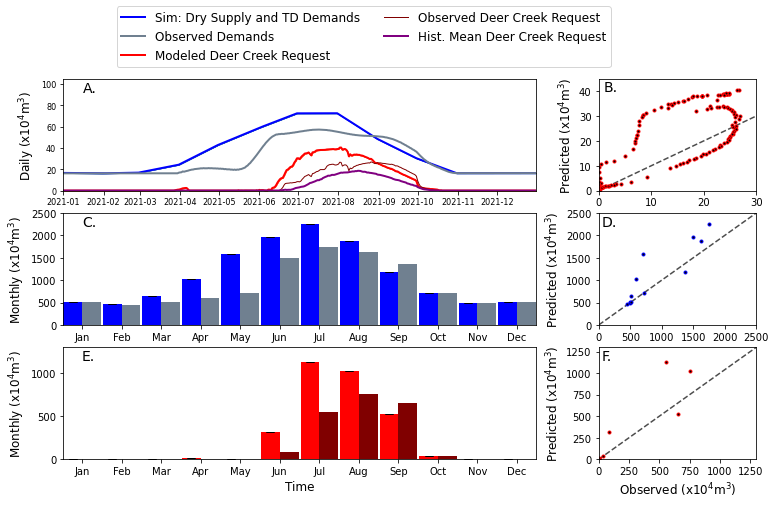

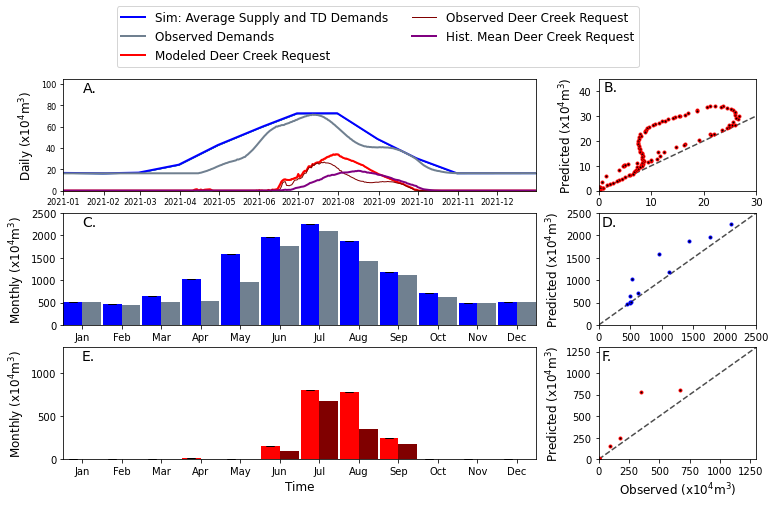

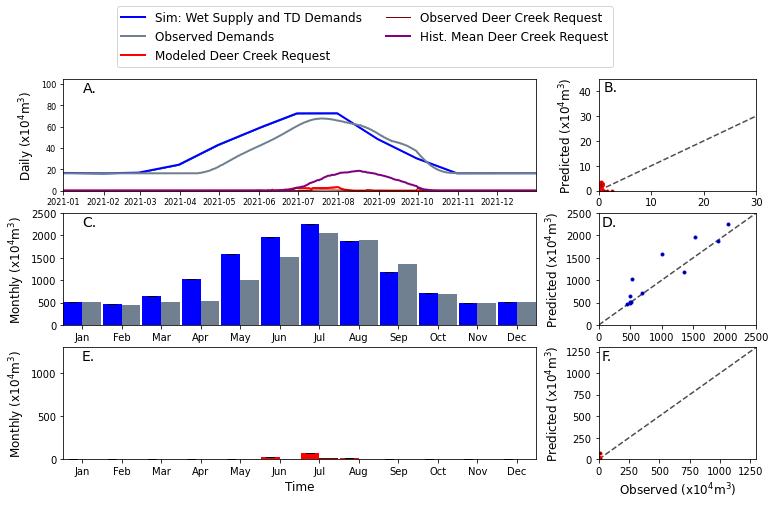

In [24]:
'''
This line omits the errors in traditional demands
'''


sup = ['Drought', 'Average', 'Surplus']
Demands = ['TD']# 'CSD_WDM']#,'TD', 'CSD_WDM'] #'TD'




Indcons = 0
Outcons = 0
maxseverity = 1

for i in sup:
    for d in Demands:
        
        SysSim = i + '_S_'+d+'_Ind0_Out0'
        SysSimO = i + '_S_OBSD_Ind0_Out0'
        
        SysSimL = SysSim+'_Lo'
        SysSimH = SysSim+'_Hi'
        
        DemandL = d+'_Lo'
        Demand = d
        DemandH = d+'_Hi'
        DemandO = 'Obs'
        
        DellSim = i + '_S_' + d + '_Dell'
        DellSimO = i + '_S_OBSD_Dell'
        DellSimL = DellSim +'_Lo'
        DellSimH = DellSim + '_Hi'
        modeltype = d
        Clim_Scenario = i +' Supply and '+ d +' Demands'

         #This does the mean
        Daily2021, Monthly2021, Dell2021 = ForecastDataPrep(GSResults[SysSim], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSim], Clim_Scenario)
         #This does the Observed
        Daily2021_O, Monthly2021_O, Dell2021_O = ForecastDataPrep(GSResults[SysSimO], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSimO], Clim_Scenario)
        
        
        
     #Plot the information
        Sup_Dem_Figure_Err_CSD(Daily2021, Monthly2021, Daily2021, Monthly2021,
                   Daily2021, Monthly2021, Daily2021_O, Monthly2021_O, 
                   2021,Indcons, Outcons, FigPath, Clim_Scenario, modeltype)

C:\Users\RJOHNS~1\AppData\Local\Temp/ipykernel_28896/4067824212.py:189: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(right=1)
C:\Users\RJOHNS~1\AppData\Local\Temp/ipykernel_28896/4067824212.py:189: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(right=1)
C:\Users\RJOHNS~1\AppData\Local\Temp/ipykernel_28896/4067824212.py:189: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(right=1)


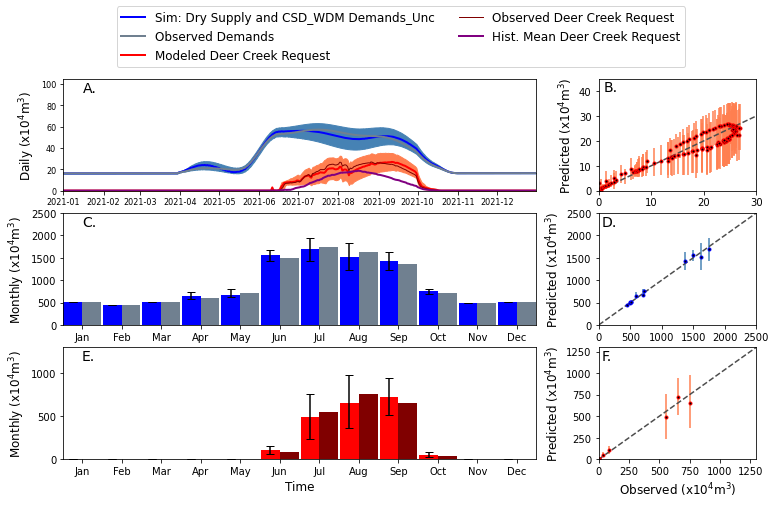

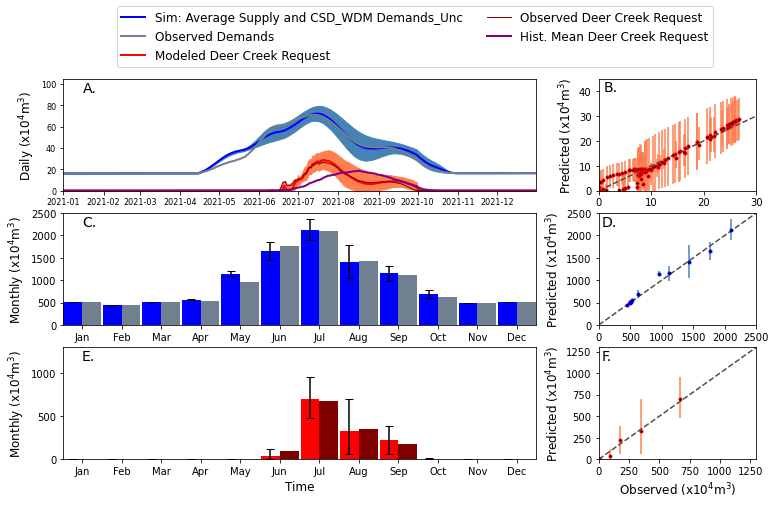

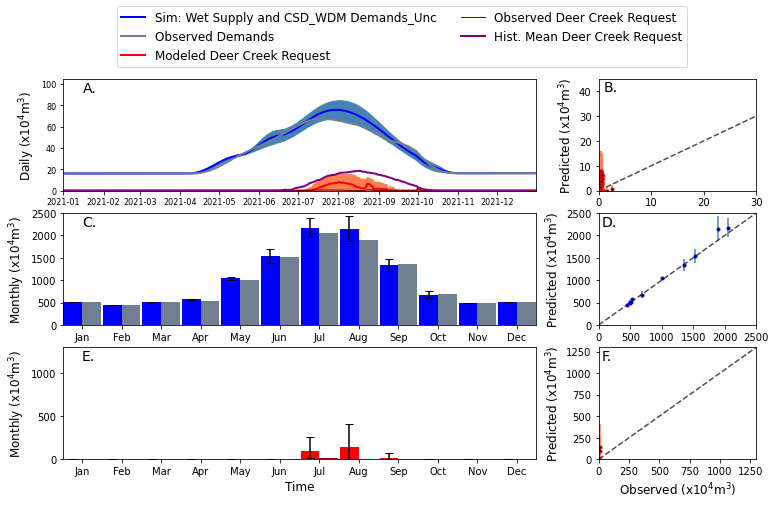

In [22]:
'''
This section adds limits to illustrate the range of uncertainty in systems analysis due to demand uncertainty

'''


sup = ['Drought', 'Average', 'Surplus']
Demands = ['CSD_WDM']#, 'TD']#,'TD', 'CSD_WDM'] #'TD'




Indcons = 0
Outcons = 0
maxseverity = 1

for i in sup:
    for d in Demands:
        
        SysSim = i + '_S_'+d+'_Ind0_Out0'
        SysSimO = i + '_S_OBSD_Ind0_Out0'
        
        SysSimL = SysSim+'_Lo'
        SysSimH = SysSim+'_Hi'
        
        DemandL = d+'_Lo'
        Demand = d
        DemandH = d+'_Hi'
        DemandO = 'Obs'
        
        DellSim = i + '_S_' + d + '_Dell'
        DellSimO = i + '_S_OBSD_Dell'
        DellSimL = DellSim +'_Lo'
        DellSimH = DellSim + '_Hi'
        modeltype = d
        Clim_Scenario = i +' Supply and '+ d +' Demands_Unc'

        #This does the low range
        Daily2021_L, Monthly2021_L, Dell2021_L = ForecastDataPrep(GSResults[SysSimL], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSimL], Clim_Scenario)
        
        #This does the mean
        Daily2021, Monthly2021, Dell2021 = ForecastDataPrep(GSResults[SysSim], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSim], Clim_Scenario)
        
        #This does the High range
        Daily2021_H, Monthly2021_H, Dell2021_H = ForecastDataPrep(GSResults[SysSimH], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSimH], Clim_Scenario)
        
        #This does the Observed
        Daily2021_O, Monthly2021_O, Dell2021_O = ForecastDataPrep(GSResults[SysSimO], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSimO], Clim_Scenario)
        
        
        
     #Plot the information
        Sup_Dem_Figure_Err_CSD(Daily2021, Monthly2021, Daily2021_L, Monthly2021_L,
                   Daily2021_H, Monthly2021_H, Daily2021_O, Monthly2021_O, 
                   2021,Indcons, Outcons, FigPath, Clim_Scenario, modeltype)
        

In [17]:
'''
This section adds limits to illustrate the range of uncertainty in systems analysis due to demand uncertainty

'''


sup = ['Drought', 'Average', 'Surplus']
Demands = ['CSD_WDM']#, 'TD']#,'TD', 'CSD_WDM'] #'TD'




Indcons = 0
Outcons = 0
maxseverity = 1

for i in sup:
    for d in Demands:
        
        SysSim = i + '_S_'+d+'_Ind0_Out0'
        SysSimO = i + '_S_OBSD_Ind0_Out0'
        
        SysSimL = SysSim+'_Lo'
        SysSimH = SysSim+'_Hi'
        
        DemandL = d+'_Lo'
        Demand = d
        DemandH = d+'_Hi'
        DemandO = 'Obs'
        
        DellSim = i + '_S_' + d + '_Dell'
        DellSimO = i + '_S_OBSD_Dell'
        DellSimL = DellSim +'_Lo'
        DellSimH = DellSim + '_Hi'
        modeltype = d
        Clim_Scenario = i +' Supply and '+ d +' Demands'

        #This does the low range
        Daily2021_L, Monthly2021_L, Dell2021_L = ForecastDataPrep(GSResults[SysSimL], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSimL], Clim_Scenario)
        
        #This does the mean
        Daily2021, Monthly2021, Dell2021 = ForecastDataPrep(GSResults[SysSim], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSim], Clim_Scenario)
        
        #This does the High range
        Daily2021_H, Monthly2021_H, Dell2021_H = ForecastDataPrep(GSResults[SysSimH], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSimH], Clim_Scenario)
        
        #This does the Observed
        Daily2021_O, Monthly2021_O, Dell2021_O = ForecastDataPrep(GSResults[SysSimO], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSimO], Clim_Scenario)
        
        
        
     #Plot the information
 #       Sup_Dem_Figure_Err_CSD(Daily2021, Monthly2021, Daily2021_L, Monthly2021_L,
  #                 Daily2021_H, Monthly2021_H, Daily2021_O, Monthly2021_O, 
   #                2021,Indcons, Outcons, FigPath, Clim_Scenario, modeltype)
        
    #Determine RRV
    #Low
        Rel_D, Res_D, Vul_D, Daily2021RRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(Daily2021_L, i, DemandL, Historical_Max_Daily_DC, 'Daily', 2021)
        print('For Daily scenario ', Clim_Scenario)
        print('Reliability: ', Rel_D, 'Resilience: ', Res_D, 'Vulnerability: ', Vul_D)
        RRVass_D = list([i, DemandL, Rel_D, Res_D, Vul_D, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_D = RRV_Assessment_D.reset_index(drop=True)
        RRV_Assessment_D.loc[len(RRV_Assessment_D.index)] = RRVass_D
        RRV_Data_D = RRV_Data_D.append(Daily2021RRV)
    
    #Mean
        Rel_D, Res_D, Vul_D, Daily2021RRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(Daily2021, i, Demand, Historical_Max_Daily_DC, 'Daily', 2021)
        print('For Daily scenario ', Clim_Scenario)
        print('Reliability: ', Rel_D, 'Resilience: ', Res_D, 'Vulnerability: ', Vul_D)
        RRVass_D = list([i, Demand, Rel_D, Res_D, Vul_D, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_D = RRV_Assessment_D.reset_index(drop=True)
        RRV_Assessment_D.loc[len(RRV_Assessment_D.index)] = RRVass_D
        RRV_Data_D = RRV_Data_D.append(Daily2021RRV)
       
    #High
        Rel_D, Res_D, Vul_D, Daily2021RRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(Daily2021_H, i, DemandH, Historical_Max_Daily_DC, 'Daily', 2021)
        print('For Daily scenario ', Clim_Scenario)
        print('Reliability: ', Rel_D, 'Resilience: ', Res_D, 'Vulnerability: ', Vul_D)
        RRVass_D = list([i, DemandH, Rel_D, Res_D, Vul_D, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_D = RRV_Assessment_D.reset_index(drop=True)
        RRV_Assessment_D.loc[len(RRV_Assessment_D.index)] = RRVass_D
        RRV_Data_D = RRV_Data_D.append(Daily2021RRV)
       
    
    #Obs
        Rel_D, Res_D, Vul_D, Daily2021RRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(Daily2021_O, i, DemandO, Historical_Max_Daily_DC, 'Daily', 2021)
        print('For Daily scenario ', Clim_Scenario)
        print('Reliability: ', Rel_D, 'Resilience: ', Res_D, 'Vulnerability: ', Vul_D)
        RRVass_D = list([i, DemandO, Rel_D, Res_D, Vul_D, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_D = RRV_Assessment_D.reset_index(drop=True)
        RRV_Assessment_D.loc[len(RRV_Assessment_D.index)] = RRVass_D
        RRV_Data_D = RRV_Data_D.append(Daily2021RRV)
        
    #Monthly RRV Low
        Rel_M, Res_M, Vul_M, Monthly2021RRV, Max_Severity,MaxSevSI, MaxSevNorm = RRV(Monthly2021_L, i, DemandL, Historical_Max_Monthly_DC, 'Monthly', 2021)
        print('For Monthly scenario ', Clim_Scenario)
        print('Reliability: ', Rel_M, 'Resilience: ', Res_M, 'Vulnerability: ', Vul_M)
        RRVass_M = list([i, DemandL, Rel_M, Res_M, Vul_M, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_M = RRV_Assessment_M.reset_index(drop=True)
        RRV_Assessment_M.loc[len(RRV_Assessment_M.index)] = RRVass_M
        Monthly2021RRV['AveT_Demands'] = np.array(MaveDemandT[3:10])
        Monthly2021RRV['AveT_Stream'] = np.array(MaveStreamT[3:10])
        Monthly2021RRV['Perc_Demand'] = ((Monthly2021RRV['SLCDPU_Prod_Demands']-Monthly2021RRV['AveT_Demands'])/Monthly2021RRV['AveT_Demands'])*100
        Monthly2021RRV['Perc_Stream'] = ((Monthly2021RRV['SLCDPU_Streamflow']-Monthly2021RRV['AveT_Stream'])/Monthly2021RRV['AveT_Stream'])*100
        RRV_Data_M = RRV_Data_M.append(Monthly2021RRV)
        
    #Monthly RRV Mean
        Rel_M, Res_M, Vul_M, Monthly2021RRV, Max_Severity,MaxSevSI, MaxSevNorm = RRV(Monthly2021, i, Demand, Historical_Max_Monthly_DC, 'Monthly', 2021)
        print('For Monthly scenario ', Clim_Scenario)
        print('Reliability: ', Rel_M, 'Resilience: ', Res_M, 'Vulnerability: ', Vul_M)
        RRVass_M = list([i, Demand, Rel_M, Res_M, Vul_M, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_M = RRV_Assessment_M.reset_index(drop=True)
        RRV_Assessment_M.loc[len(RRV_Assessment_M.index)] = RRVass_M
        Monthly2021RRV['AveT_Demands'] = np.array(MaveDemandT[3:10])
        Monthly2021RRV['AveT_Stream'] = np.array(MaveStreamT[3:10])
        Monthly2021RRV['Perc_Demand'] = ((Monthly2021RRV['SLCDPU_Prod_Demands']-Monthly2021RRV['AveT_Demands'])/Monthly2021RRV['AveT_Demands'])*100
        Monthly2021RRV['Perc_Stream'] = ((Monthly2021RRV['SLCDPU_Streamflow']-Monthly2021RRV['AveT_Stream'])/Monthly2021RRV['AveT_Stream'])*100
        RRV_Data_M = RRV_Data_M.append(Monthly2021RRV)
        
    #Monthly RRV High
        Rel_M, Res_M, Vul_M, Monthly2021RRV, Max_Severity,MaxSevSI, MaxSevNorm = RRV(Monthly2021_H, i, DemandH, Historical_Max_Monthly_DC, 'Monthly', 2021)
        print('For Monthly scenario ', Clim_Scenario)
        print('Reliability: ', Rel_M, 'Resilience: ', Res_M, 'Vulnerability: ', Vul_M)
        RRVass_M = list([i, DemandH, Rel_M, Res_M, Vul_M, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_M = RRV_Assessment_M.reset_index(drop=True)
        RRV_Assessment_M.loc[len(RRV_Assessment_M.index)] = RRVass_M
        Monthly2021RRV['AveT_Demands'] = np.array(MaveDemandT[3:10])
        Monthly2021RRV['AveT_Stream'] = np.array(MaveStreamT[3:10])
        Monthly2021RRV['Perc_Demand'] = ((Monthly2021RRV['SLCDPU_Prod_Demands']-Monthly2021RRV['AveT_Demands'])/Monthly2021RRV['AveT_Demands'])*100
        Monthly2021RRV['Perc_Stream'] = ((Monthly2021RRV['SLCDPU_Streamflow']-Monthly2021RRV['AveT_Stream'])/Monthly2021RRV['AveT_Stream'])*100
        RRV_Data_M = RRV_Data_M.append(Monthly2021RRV)
        
    #Monthly RRV Obs
        Rel_M, Res_M, Vul_M, Monthly2021RRV, Max_Severity,MaxSevSI, MaxSevNorm = RRV(Monthly2021_O, i, DemandO, Historical_Max_Monthly_DC, 'Monthly', 2021)
        print('For Monthly scenario ', Clim_Scenario)
        print('Reliability: ', Rel_M, 'Resilience: ', Res_M, 'Vulnerability: ', Vul_M)
        RRVass_M = list([i, DemandO, Rel_M, Res_M, Vul_M, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_M = RRV_Assessment_M.reset_index(drop=True)
        RRV_Assessment_M.loc[len(RRV_Assessment_M.index)] = RRVass_M
        Monthly2021RRV['AveT_Demands'] = np.array(MaveDemandT[3:10])
        Monthly2021RRV['AveT_Stream'] = np.array(MaveStreamT[3:10])
        Monthly2021RRV['Perc_Demand'] = ((Monthly2021RRV['SLCDPU_Prod_Demands']-Monthly2021RRV['AveT_Demands'])/Monthly2021RRV['AveT_Demands'])*100
        Monthly2021RRV['Perc_Stream'] = ((Monthly2021RRV['SLCDPU_Streamflow']-Monthly2021RRV['AveT_Stream'])/Monthly2021RRV['AveT_Stream'])*100
        RRV_Data_M = RRV_Data_M.append(Monthly2021RRV)
        
        
RRV_Assessment_D = RRV_Assessment_D.drop_duplicates()
RRV_Assessment_M = RRV_Assessment_M.drop_duplicates()

C:\Users\rjohnson18\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Daily scenario  Drought Supply and CSD_WDM Demands
Reliability:  0.7616822429906542 Resilience:  17.333333333333332 Vulnerability:  0.32744893339296033
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Daily scenario  Drought Supply and CSD_WDM Demands
Reliability:  0.48130841121495327 Resilience:  28.0 Vulnerability:  0.4376280226342143
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severi

Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Daily scenario  Average Supply and TD Demands
Reliability:  0.7289719626168224 Resilience:  29.5 Vulnerability:  0.31291863023630484
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Daily scenario  Average Supply and TD Demands
Reliability:  0.6074766355140186 Resilience:  17.0 Vulnerability:  0.4750514048091226
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
  

In [18]:
#need to add to the historical RRV assessments to determine breaks
years =  [2001,2002,2003,2004, 2005, 2006, 2007,2008, 2009, 2010,
          2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,2020]
RRV_Assessment_D = RRV_Assessment_D.reset_index(drop=True)
RRV_Assessment_M = RRV_Assessment_M.reset_index(drop=True)

Clim_Scenario = 'Historical'
modeltype = 'Obs'
for y in years:
    HistDay = Hist.loc[str(y)+'-01-01':str(y)+'-12-31'].copy()
    HistMonth = HistM.loc[str(y)+'-01-01':str(y)+'-12-31'].copy()
    #HistMonth.index =  pd.to_datetime(HistMonth.index, format='%m').month_name().str.slice(stop=3)
    Rel_D, Res_D, Vul_D, DailyRRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(HistDay, 'Hist', 'Obs', Historical_Max_Daily_DC, 'Daily',y)
    print('For Daily scenario ', Clim_Scenario)
    print('Reliability: ', Rel_D, 'Resilience: ', Res_D, 'Vulnerability: ', Vul_D)
    RRVass_D = list(['Hist', 'Obs', Rel_D, Res_D, Vul_D, Max_Severity,MaxSevSI, MaxSevNorm])
    RRV_Assessment_D = RRV_Assessment_D.reset_index(drop=True)
    RRV_Assessment_D.loc[len(RRV_Assessment_D.index)] = RRVass_D
    RRV_Data_D = RRV_Data_D.append(DailyRRV)

    Rel_M, Res_M, Vul_M, MonthlyRRV, Max_Severity,MaxSevSI, MaxSevNorm = RRV(HistMonth, 'Hist', 'Obs', Historical_Max_Monthly_DC, 'Monthly',y)
    print('For Monthly scenario ', Clim_Scenario)
    print('Reliability: ', Rel_M, 'Resilience: ', Res_M, 'Vulnerability: ', Vul_M)
    RRVass_M = list(['Hist', 'Obs', Rel_M, Res_M, Vul_M, Max_Severity,MaxSevSI, MaxSevNorm])
    RRV_Assessment_M = RRV_Assessment_M.reset_index(drop=True)
    RRV_Assessment_M.loc[len(RRV_Assessment_M.index)] = RRVass_M
    RRV_Data_M = RRV_Data_M.append(MonthlyRRV)
    RRV_Data_M['AveT_Demands'] = MaveDemandT
    RRV_Data_M['AveT_Stream'] = MaveStreamT
    RRV_Data_M['Perc_Demand'] = ((RRV_Data_M['SLCDPU_Prod_Demands']-RRV_Data_M['AveT_Demands'])/RRV_Data_M['AveT_Demands'])*100
    RRV_Data_M['Perc_Stream'] = ((RRV_Data_M['SLCDPU_Streamflow']-RRV_Data_M['AveT_Stream'])/RRV_Data_M['AveT_Stream'])*100


Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Daily scenario  Historical
Reliability:  0.6074766355140186 Resilience:  42.5 Vulnerability:  0.3540292966762114
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Time', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Monthly scenario  Historical
Reliability:  0.42857142857142855 Resilience:  5.0 Vulnerability:  0.39853556357413344
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
F

Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Time', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Monthly scenario  Historical
Reliability:  0.5714285714285714 Resilience:  4.0 Vulnerability:  0.3685815199453192
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Daily scenario  Historical
Reliability:  1.0 Resilience:  1.0 Vulnerability:  0.06741557159302704
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Time', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For

In [19]:
keyrows = ['Drought_Obs','Drought_TD',  'Drought_CSD_WDM', 
           'Average_Obs', 'Average_TD', 'Average_CSD_WDM',
           'Surplus_Obs', 'Surplus_TD', 'Surplus_CSD_WDM']

RRV_AssD = RRV_Assessment_D.loc[keyrows]
RRV_AssM = RRV_Assessment_M.loc[keyrows]

RRV_ErrorLD, RRV_ErrorHD = RRV_UncertainDF(RRV_Assessment_D)
RRV_ErrorLM, RRV_ErrorHM = RRV_UncertainDF(RRV_Assessment_M)

RRVplotsErr(RRV_AssD, 'Day', RRV_ErrorLD, RRV_ErrorHD)
RRVplotsErr(RRV_AssM, 'Month', RRV_ErrorLM, RRV_ErrorHM)

KeyError: "None of [Index(['Drought_Obs', 'Drought_TD', 'Drought_CSD_WDM', 'Average_Obs',\n       'Average_TD', 'Average_CSD_WDM', 'Surplus_Obs', 'Surplus_TD',\n       'Surplus_CSD_WDM'],\n      dtype='object')] are in the [index]"

In [180]:
RRV_Data_D.loc[(RRV_Data_D['Clim']== 'Drought') & (RRV_Data_D['Demand']=='Obs')]

,SLCDPU_Prod_Demands,SLCDPU_Shortages,SLCDPU_GW,SLCDPU_Streamflow,SLCDPU_DC_Water_Use,Hist_Mean_DC_Delivery,Extra_DC,ExtraDC,Zt,Wt,WRI_s,Severity,Vulnerability,Clim,Demand
2021-04-01,17.059028,0.0,5.675241,9.919646,0.007339,0.002202,0.0,NaN,1,0,0.007323,0.0,0.003662,Drought,Obs
2021-04-02,17.182376,0.0,6.203171,9.672950,0.007339,0.002569,0.0,NaN,1,0,0.007320,0.0,0.003660,Drought,Obs
2021-04-03,17.996473,0.0,7.478589,9.327576,0.007339,0.002202,0.0,NaN,1,0,0.007323,0.0,0.003662,Drought,Obs
2021-04-04,17.725108,0.0,7.096210,9.500263,0.007339,0.002569,0.0,NaN,1,0,0.007320,0.0,0.003660,Drought,Obs
2021-04-05,18.082817,0.0,7.113479,9.524933,0.007339,0.002202,0.0,NaN,1,0,0.007323,0.0,0.003662,Drought,Obs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27,16.923346,0.0,6.411629,9.642113,0.007339,0.004404,0.0,NaN,1,0,0.007307,0.0,0.003654,Drought,Obs
2021-10-28,16.688984,0.0,5.903435,10.451276,0.007339,0.004404,0.0,NaN,1,0,0.007307,0.0,0.003654,Drought,Obs
2021-10-29,16.528632,0.0,6.719999,9.833303,0.007339,0.004404,0.0,NaN,1,0,0.007307,0.0,0.003654,Drought,Obs
2021-10-30,16.417619,0.0,6.441233,10.135505,0.007339,0.004404,0.0,NaN,1,0,0.007307,0.0,0.003654,Drought,Obs


In [222]:
d = 'CSD_WDM_Hi'
s = 'Drought'

x = RRV_Data_D.loc[(RRV_Data_D['Clim']== s) & (RRV_Data_D['Demand']==d)]
y = RRV_Data_M.loc[(RRV_Data_M['Clim']== s) & (RRV_Data_M['Demand']==d)]

x = x[~x.index.duplicated(keep='first')]
y = y[~y.index.duplicated(keep='first')]

#x.loc['2021-06-15':'2021-07-30']
#number of days of extra DC water
DCextraD = len(x.loc[x['Extra_DC']> 5])
DCextraM = len(y.loc[y['Extra_DC']> 5])

In [223]:
y.loc[y['Extra_DC']> 5]

,SLCDPU_Prod_Demands,SLCDPU_Shortages,SLCDPU_GW,SLCDPU_Streamflow,SLCDPU_DC_Water_Use,Hist_Mean_DC_Delivery,Extra_DC,Zt,Wt,WRI_s,Severity,Vulnerability,Clim,Demand,AveT_Demands,AveT_Stream,Perc_Demand,Perc_Stream,Time
2021-06-30,1679.469364,0.03212,327.180570,1333.663246,152.461890,15.654484,137.142002,0,0,1.0,0.210230,0.605115,Drought,CSD_WDM_Hi,NaN,NaN,NaN,NaN,NaT
2021-07-31,1937.427036,0.00000,342.190788,584.003441,755.901214,294.770257,461.130957,0,0,1.0,0.706884,0.853442,Drought,CSD_WDM_Hi,NaN,NaN,NaN,NaN,NaT
2021-08-31,1829.300179,0.00000,342.190788,340.724180,972.635984,532.207794,440.428191,0,0,1.0,0.675148,0.837574,Drought,CSD_WDM_Hi,NaN,NaN,NaN,NaN,NaT
2021-09-30,1628.946023,0.00000,331.152376,221.536708,942.822773,293.628533,649.194239,0,0,1.0,0.995172,0.997586,Drought,CSD_WDM_Hi,NaN,NaN,NaN,NaN,NaT
2021-10-31,796.211340,0.00000,306.109031,384.754482,88.622578,17.575408,71.047170,0,0,1.0,0.108911,0.554455,Drought,CSD_WDM_Hi,NaN,NaN,NaN,NaN,NaT


In [215]:
y.loc[y['Extra_DC']> 5]

,SLCDPU_Prod_Demands,SLCDPU_Shortages,SLCDPU_GW,SLCDPU_Streamflow,SLCDPU_DC_Water_Use,Hist_Mean_DC_Delivery,Extra_DC,Zt,Wt,WRI_s,Severity,Vulnerability,Clim,Demand,AveT_Demands,AveT_Stream,Perc_Demand,Perc_Stream,Time
2021-06-30,1679.469364,0.03212,327.180570,1333.663246,152.461890,15.654484,137.142002,0,0,1.0,0.210230,0.605115,Drought,CSD_WDM_Hi,NaN,NaN,NaN,NaN,NaT
2021-07-31,1937.427036,0.00000,342.190788,584.003441,755.901214,294.770257,461.130957,0,0,1.0,0.706884,0.853442,Drought,CSD_WDM_Hi,NaN,NaN,NaN,NaN,NaT
2021-08-31,1829.300179,0.00000,342.190788,340.724180,972.635984,532.207794,440.428191,0,0,1.0,0.675148,0.837574,Drought,CSD_WDM_Hi,NaN,NaN,NaN,NaN,NaT
2021-09-30,1628.946023,0.00000,331.152376,221.536708,942.822773,293.628533,649.194239,0,0,1.0,0.995172,0.997586,Drought,CSD_WDM_Hi,NaN,NaN,NaN,NaN,NaT
2021-10-31,796.211340,0.00000,306.109031,384.754482,88.622578,17.575408,71.047170,0,0,1.0,0.108911,0.554455,Drought,CSD_WDM_Hi,NaN,NaN,NaN,NaN,NaT
2021-06-30,1679.469364,0.03212,327.180570,1333.663246,152.461890,15.654484,137.142002,0,0,1.0,0.210230,0.605115,Drought,CSD_WDM_Hi,1459.747721,3204.590291,15.052028,-58.382722,NaT
2021-07-31,1937.427036,0.00000,342.190788,584.003441,755.901214,294.770257,461.130957,0,0,1.0,0.706884,0.853442,Drought,CSD_WDM_Hi,1839.911808,1616.449267,5.299995,-63.871217,NaT
2021-08-31,1829.300179,0.00000,342.190788,340.724180,972.635984,532.207794,440.428191,0,0,1.0,0.675148,0.837574,Drought,CSD_WDM_Hi,1722.337728,659.257501,6.210306,-48.316981,NaT
2021-09-30,1628.946023,0.00000,331.152376,221.536708,942.822773,293.628533,649.194239,0,0,1.0,0.995172,0.997586,Drought,CSD_WDM_Hi,1238.755594,452.485918,31.498581,-51.040088,NaT
2021-10-31,796.211340,0.00000,306.109031,384.754482,88.622578,17.575408,71.047170,0,0,1.0,0.108911,0.554455,Drought,CSD_WDM_Hi,630.213126,401.770104,26.340012,-4.235164,NaT


In [224]:
MaveStreamT = HistMonthly['SLCDPU_Streamflow']
MaveDemandT = HistMonthly['SLCDPU_Prod_Demands']
MaveDC = HistMonthly['SLCDPU_DC_Water_Use']
MaveExtraDC = HistMonthly['Extra_DC']
SeasonExtraDC = MaveExtraDC.sum()

NonRRVassessment =pd.DataFrame(columns =['Climate', 'Demand','DCmaxD','DCmaxM', 'maxDemD','maxDemM','maxDemMMonth', 'DCextraD', 'DCextraM', 'DCmaxDate', 'DCAAmax', 'DCAAmaxDate',
                        'DCmaxM','DCmaxMonth','DCAAmaxM','DCAAmaxMonth', 'SeasonD', 'SeasonDR', 
                        'SeasonDC','SeasonDCextra', 'SeasonStrm', 
                        'SeasonStrmRatio'])
sup = ['Drought']
Demands = ['Obs', 'TD', 'CSD_WDM_Lo', 'CSD_WDM', 'CSD_WDM_Hi']

for s in sup:
    for d in Demands:    
        x = RRV_Data_D.loc[(RRV_Data_D['Clim']== s) & (RRV_Data_D['Demand']==d)]
        y = RRV_Data_M.loc[(RRV_Data_M['Clim']== s) & (RRV_Data_M['Demand']==d)]
        x = x[~x.index.duplicated(keep='first')]
        y = y[~y.index.duplicated(keep='first')]
        #x.loc['2021-06-15':'2021-07-30']
        #number of days of extra DC water
        DCextraD = len(x.loc[x['Extra_DC']> 0])
        DCextraM = len(y.loc[y['Extra_DC']> 100])
        #max slcdpu demand
        maxDemD = x['SLCDPU_Prod_Demands'].max()
        
        #Max Day
        DCmaxD = x['SLCDPU_DC_Water_Use'].max()
        DCmaxDate = x.loc[x['SLCDPU_DC_Water_Use']==DCmaxD].index
        DCmaxDate = DCmaxDate.format('%Y-%m-%d')[1]
        
        #DC above average max
        DCAAmax = x['Extra_DC'].max()
        DCAAmaxM = y['Extra_DC'].max()
        DCAAmaxDate = x.loc[x['Extra_DC']==DCAAmax].index
        DCAAmaxDate = DCAAmaxDate.format('%Y-%m-%d')[1]
        DCAAmax = DCAAmax
        
        #peak month
        maxDemM = y['SLCDPU_Prod_Demands'].max()
        DCmaxM = y['SLCDPU_DC_Water_Use'].max()
        maxDemMMonth = y.loc[y['SLCDPU_Prod_Demands']==maxDemM].index
        maxDemMMonth = maxDemMMonth.format('%Y-%m-%d')[1]
        
        DCmaxMonth = y.loc[y['SLCDPU_DC_Water_Use']==DCmaxM].index
        DCmaxMonth = DCmaxMonth.format('%Y-%m-%d')[1]
        
        #DC above aveage month
        DCAAmaxM = y['Extra_DC'].max()
        DCAAmaxMonth = y.loc[y['Extra_DC']==DCAAmaxM].index
        DCAAmaxMonth = DCAAmaxMonth.format('%Y-%m-%d')[1]
        DCAAmaxM =DCAAmaxM
        
        
        #Find the total season demands
        SeasonD = y['SLCDPU_Prod_Demands'].sum()
        SeasonD_Perc = ((SeasonD-SeasAveDemand)/SeasAveDemand)*100
        SeasonDR =SeasonD/SeasAveDemand
        
        SeasonDC = y['SLCDPU_DC_Water_Use'].sum()
        SeasonDC_Perc = ((SeasonDC-SeasAveDC)/SeasAveDC)*100
        SeasonDC = SeasonDC
        
        SeasonDCextra = y['Extra_DC'].sum()
        SeasonDCextra_Perc = ((SeasonDCextra-SeasonExtraDC)/SeasonExtraDC)*100
        SeasonDCextra = SeasonDCextra
        
        SeasonStrm = y['SLCDPU_Streamflow'].sum()
        SeasonStrm_Perc = ((SeasonStrm-SeasAveStream)/SeasAveStream)*100
        SeasonStrmRatio = ((SeasonStrm)/SeasAveStream)
        
        
        SimStats =list([s, d,DCmaxD,DCmaxM, maxDemD,maxDemM,maxDemMMonth, DCextraD, DCextraM, DCmaxDate, DCAAmax, DCAAmaxDate,DCmaxM, DCmaxMonth,
                         DCAAmaxM,DCAAmaxMonth, SeasonD,SeasonDR,
                        SeasonDC,SeasonDCextra, SeasonStrm, SeasonStrmRatio])
        
        #print(SimStats)
        NonRRVassessment.loc[len(NonRRVassessment)] = SimStats

In [225]:
NonRRVassessment

,Climate,Demand,DCmaxD,DCmaxM,maxDemD,maxDemM,maxDemMMonth,DCextraD,DCextraM,DCmaxDate,...,DCmaxM,DCmaxMonth,DCAAmaxM,DCAAmaxMonth,SeasonD,SeasonDR,SeasonDC,SeasonDCextra,SeasonStrm,SeasonStrmRatio
0,Drought,Obs,26.889864,754.347029,57.245807,1749.160984,2021-07-31,111,3,2021-08-26,...,754.347029,2021-08-31,356.637453,2021-09-30,8260.442873,1.026502,2077.568545,924.189095,4962.704489,0.526174
1,Drought,TD,40.433474,1127.548738,72.577963,2248.683379,2021-07-31,127,4,2021-08-03,...,1127.548738,2021-07-31,832.778481,2021-07-31,10566.174702,1.313029,3042.509877,1888.429227,5753.458914,0.610015
2,Drought,CSD_WDM_Lo,19.390306,514.313054,51.226424,1425.594510,2021-06-30,51,1,2021-09-12,...,514.313054,2021-09-30,220.684521,2021-09-30,7183.614833,0.892688,1194.398025,293.299750,5753.458914,0.610015
3,Drought,CSD_WDM,26.902199,721.302100,56.086336,1689.053503,2021-07-31,111,3,2021-09-11,...,721.302100,2021-09-30,427.673566,2021-09-30,8271.803224,1.027914,2026.220081,878.167552,4962.704489,0.526174
4,Drought,CSD_WDM_Hi,35.536559,972.635984,63.326863,1937.427036,2021-07-31,123,4,2021-09-06,...,972.635984,2021-08-31,649.194239,2021-09-30,9409.158127,1.169250,2912.682975,1758.942558,5753.458914,0.610015


In [143]:
NonRRVassessment.columns

Index(['Climate', 'Demand', 'DCmaxD', 'DCmaxM', 'maxDemD', 'maxDemM',
       'maxDemMMonth', 'DCextraD', 'DCextraM', 'DCmaxDate', 'DCAAmax',
       'DCAAmaxDate', 'DCmaxM', 'DCmaxMonth', 'DCAAmaxM', 'DCAAmaxMonth',
       'MaxPercHist_DM', 'MaxPercHist_StrmM', 'SeasonD', 'SeasonDR',
       'SeasonD_Perc', 'SeasonDC', 'SeasonDC_Perc', 'SeasonDCextra',
       'SeasonDCextra_Perc', 'SeasonStrm', 'SeasonStrm_Perc',
       'SeasonStrmRatio'],
      dtype='object')

In [144]:
#columns =['Climate', 'Demand', 'DCmaxD', 'maxDemD','maxDemM', 'DCextraD', 'DCextraM', 'DCmaxDate', 'DCAAmax', 'DCAAmaxDate',
                #        'DCmaxM','DCmaxMonth','DCAAmaxM','DCAAmaxMonth']
NonRRVassessment['DCmaxMonth']

0    2021-09-30
1    2021-09-30
2    2021-08-31
Name: DCmaxMonth, dtype: object

In [146]:
def Sensitivity(df1, df2):
    df = pd.concat([df1, df2], axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    DemVarDrought = df[df['Climate'] == 'Drought'].copy()
    DemVarAve = df[df['Climate'] == 'Average'].copy()
    DemVarSurplus = df[df['Climate'] == 'Surplus'].copy()
    
    SupVarObs = df[df['Demand'] == 'OBSD'].copy()
    SupVarTrad = df[df['Demand'] == 'TD'].copy()
    SupVarCSD = df[df['Demand'] == 'CSD_WDM'].copy()
    
    Demands = [DemVarDrought, DemVarAve, DemVarSurplus]
    Supply = [SupVarObs, SupVarTrad, SupVarCSD]
    
    RelRange_D = []
    ResRange_D = []
    AVRange_D = []
    PSRange_D = []
    
    #for Demand
    for i in Demands:
        Rel = (max(i['Reliability'])-min(i['Reliability']))/(max(i['SeasonDR'])-min(i['SeasonDR']))
        Res = (max(i['Resilience'])-min(i['Resilience']))/(max(i['SeasonDR'])-min(i['SeasonDR']))
        AV = (max(i['Vulnerability'])-min(i['Vulnerability']))/(max(i['SeasonDR'])-min(i['SeasonDR']))
        PS = (max(i['Maximum_Severity'])-min(i['Maximum_Severity']))/(max(i['SeasonDR'])-min(i['SeasonDR']))
        RelRange_D.append(Rel)
        ResRange_D.append(Res)
        AVRange_D.append(AV)
        PSRange_D.append(PS)
        
        
    RelRange_S = []
    ResRange_S = []
    AVRange_S = []
    PSRange_S = []
    
    #for Supply
    for i in Supply:
        Rel = (max(i['Reliability'])-min(i['Reliability']))/(max(i['SeasonStrmRatio'])-min(i['SeasonStrmRatio']))
        Res = (max(i['Resilience'])-min(i['Resilience']))/(max(i['SeasonStrmRatio'])-min(i['SeasonStrmRatio']))
        AV = (max(i['Vulnerability'])-min(i['Vulnerability']))/(max(i['SeasonStrmRatio'])-min(i['SeasonStrmRatio']))
        PS = (max(i['Maximum_Severity'])-min(i['Maximum_Severity']))/(max(i['SeasonStrmRatio'])-min(i['SeasonStrmRatio']))
        RelRange_S.append(Rel)
        ResRange_S.append(Res)
        AVRange_S.append(AV)
        PSRange_S.append(PS)
    
    DemandSensitivity = [max(RelRange_D), max(ResRange_D), max(AVRange_D), max(PSRange_D)]
    SupplySensitivity = [ max(RelRange_S),max(ResRange_S), max(AVRange_S),max(PSRange_S)] 
    
    SensitivityDF = pd.DataFrame(columns=['Metric', 'Demand', 'Supply'])
    SensitivityDF['Metric'] = ['Reliability', 'Resilience', 'Vulnerability', 'Severity']
    SensitivityDF['Demand'] = DemandSensitivity
    SensitivityDF['Supply'] = SupplySensitivity
    return SensitivityDF
    
    
    

In [147]:
SensitivityDay = Sensitivity(RRV_Assessment_D[:9], NonRRVassessment)
SensitivityMonth = Sensitivity(RRV_Assessment_M[:9], NonRRVassessment)


In [148]:
SensitivityDay

,Metric,Demand,Supply
0,Reliability,0.771606,0.374830
1,Resilience,97.722058,34.738149
2,Vulnerability,0.627990,0.356647
3,Severity,2.321531,0.749413


In [149]:
SensitivityMonth

,Metric,Demand,Supply
0,Reliability,0.997164,0.541374
1,Resilience,6.980147,4.421219
2,Vulnerability,0.700447,0.342141
3,Severity,2.547381,0.800178


In [105]:
sum(MaveDC[3:10])

1153.7840257297516

In [106]:
SeasAveStream

9431.673248799998

In [41]:
OBS_Drought_Sim = GSResults['Drought_S_OBSD_Ind0_Out0']
FD_Drought_Sim = GSResults['Drought_S_FD_Ind0_Out0']
MLRD_Drought_Sim = GSResults['Drought_S_MLRD_Ind0_Out0']

OBS_Average_Sim = GSResults['Average_S_OBSD_Ind0_Out0']
FD_Average_Sim = GSResults['Average_S_FD_Ind0_Out0']
MLRD_Average_Sim = GSResults['Average_S_MLRD_Ind0_Out0']

OBS_Surplus_Sim = GSResults['Surplus_S_OBSD_Ind0_Out0']
FD_Surplus_Sim = GSResults['Surplus_S_FD_Ind0_Out0']
MLRD_Surplus_Sim = GSResults['Surplus_S_MLRD_Ind0_Out0']

In [42]:
OBS_Average_Sim[OBS_Average_Sim['Time']== '2021-07-30']

,Time,SLCDPU_Prod_Demands,SLCDPU_Streamflow,SLCDPU_Shortages,SLCDPU_GW,SLCDPU_DC_Water_Use
7607,2021-07-30,490.9,95.62,0.0,89.49,180.0


In [43]:
MLRD_Average_Sim[MLRD_Average_Sim['Time']== '2021-07-30']

,Time,SLCDPU_Prod_Demands,SLCDPU_Streamflow,SLCDPU_Shortages,SLCDPU_GW,SLCDPU_DC_Water_Use
7607,2021-07-30,502.2,95.62,0.0,89.49,191.3


In [44]:
FD_Average_Sim[FD_Average_Sim['Time']== '2021-07-30']

,Time,SLCDPU_Prod_Demands,SLCDPU_Streamflow,SLCDPU_Shortages,SLCDPU_GW,SLCDPU_DC_Water_Use
7607,2021-07-30,588.4,95.62,0.0,89.49,276.5


In [ ]:
(MonthlySum2021.SLCDPU_DC_Water_Use.sum()-MonthlySum2021.Hist_Mean_DC_Delivery.sum())/MonthlySum2021.Hist_Mean_DC_Delivery.sum()

In [ ]:
Output2021['PercentAboveDC'] =(Output2021['Extra_DC']/Output2021['Hist_Mean_DC_Delivery'])*100
Output2021.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
Output2021.loc['2021-06-1':'2021-07-30']

In [ ]:
ExtraDays = Output2021[Output2021['Extra_DC']>1 ] 
len(ExtraDays)

In [ ]:
ExtraDays = Output2021[Output2021['Extra_DC']>30 ] 
ExtraDays

In [ ]:
ExtraDays = Output2021[Output2021['SLCDPU_DC_Water_Use']>140 ] 
ExtraDays

In [ ]:
ExtraDays = Output2021[Output2021['SLCDPU_Prod_Demands']>140 ] 
ExtraDays

In [ ]:
ExtraDays = Output2021[Output2021['Hist_Mean_DC_Delivery']>10] 
ExtraDays

In [ ]:
#Percent change from scenario obs
    RRV_Assessment['Perc_Rel_Scen'] = 0
    RRV_Assessment['Perc_Rel_Scen'].iloc[0] = ((RRV_Assessment['Reliability'].iloc[0]/RRV_Assessment['Reliability'].iloc[0])*100)-100
    RRV_Assessment['Perc_Rel_Scen'].iloc[1] = ((RRV_Assessment['Reliability'].iloc[1]/RRV_Assessment['Reliability'].iloc[0])*100)-100
    RRV_Assessment['Perc_Rel_Scen'].iloc[2] = ((RRV_Assessment['Reliability'].iloc[2]/RRV_Assessment['Reliability'].iloc[0])*100)-100

    RRV_Assessment['Perc_Rel_Scen'].iloc[3] = ((RRV_Assessment['Reliability'].iloc[3]/RRV_Assessment['Reliability'].iloc[3])*100)-100
    RRV_Assessment['Perc_Rel_Scen'].iloc[4] = ((RRV_Assessment['Reliability'].iloc[4]/RRV_Assessment['Reliability'].iloc[3])*100)-100
    RRV_Assessment['Perc_Rel_Scen'].iloc[5] = ((RRV_Assessment['Reliability'].iloc[5]/RRV_Assessment['Reliability'].iloc[3])*100)-100

    RRV_Assessment['Perc_Rel_Scen'].iloc[6] = ((RRV_Assessment['Reliability'].iloc[6]/RRV_Assessment['Reliability'].iloc[6])*100)-100
    RRV_Assessment['Perc_Rel_Scen'].iloc[7] = ((RRV_Assessment['Reliability'].iloc[7]/RRV_Assessment['Reliability'].iloc[6])*100)-100
    RRV_Assessment['Perc_Rel_Scen'].iloc[8] = ((RRV_Assessment['Reliability'].iloc[8]/RRV_Assessment['Reliability'].iloc[6])*100)-100


    RRV_Assessment['Perc_Res_Scen'] = 0
    RRV_Assessment['Perc_Res_Scen'].iloc[0] = ((RRV_Assessment['Resilience'].iloc[0]/RRV_Assessment['Resilience'].iloc[0])*100)-100
    RRV_Assessment['Perc_Res_Scen'].iloc[1] = ((RRV_Assessment['Resilience'].iloc[1]/RRV_Assessment['Resilience'].iloc[0])*100)-100
    RRV_Assessment['Perc_Res_Scen'].iloc[2] = ((RRV_Assessment['Resilience'].iloc[2]/RRV_Assessment['Resilience'].iloc[0])*100)-100

    RRV_Assessment['Perc_Res_Scen'].iloc[3] = ((RRV_Assessment['Resilience'].iloc[3]/RRV_Assessment['Resilience'].iloc[3])*100)-100
    RRV_Assessment['Perc_Res_Scen'].iloc[4] = ((RRV_Assessment['Resilience'].iloc[4]/RRV_Assessment['Resilience'].iloc[3])*100)-100
    RRV_Assessment['Perc_Res_Scen'].iloc[5] = ((RRV_Assessment['Resilience'].iloc[5]/RRV_Assessment['Resilience'].iloc[3])*100)-100

    RRV_Assessment['Perc_Res_Scen'].iloc[6] = ((RRV_Assessment['Resilience'].iloc[6]/RRV_Assessment['Resilience'].iloc[6])*100)-100
    RRV_Assessment['Perc_Res_Scen'].iloc[7] = ((RRV_Assessment['Resilience'].iloc[7]/RRV_Assessment['Resilience'].iloc[6])*100)-100
    RRV_Assessment['Perc_Res_Scen'].iloc[8] = ((RRV_Assessment['Resilience'].iloc[8]/RRV_Assessment['Resilience'].iloc[6])*100)-100


    RRV_Assessment['Perc_Vul_Scen'] = 0
    RRV_Assessment['Perc_Vul_Scen'].iloc[0] = ((RRV_Assessment['Vulnerability'].iloc[0]/RRV_Assessment['Vulnerability'].iloc[0])*100)-100
    RRV_Assessment['Perc_Vul_Scen'].iloc[1] = ((RRV_Assessment['Vulnerability'].iloc[1]/RRV_Assessment['Vulnerability'].iloc[0])*100)-100
    RRV_Assessment['Perc_Vul_Scen'].iloc[2] = ((RRV_Assessment['Vulnerability'].iloc[2]/RRV_Assessment['Vulnerability'].iloc[0])*100)-100

    RRV_Assessment['Perc_Vul_Scen'].iloc[3] = ((RRV_Assessment['Vulnerability'].iloc[3]/RRV_Assessment['Vulnerability'].iloc[3])*100)-100
    RRV_Assessment['Perc_Vul_Scen'].iloc[4] = ((RRV_Assessment['Vulnerability'].iloc[4]/RRV_Assessment['Vulnerability'].iloc[3])*100)-100
    RRV_Assessment['Perc_Vul_Scen'].iloc[5] = ((RRV_Assessment['Vulnerability'].iloc[5]/RRV_Assessment['Vulnerability'].iloc[3])*100)-100

    RRV_Assessment['Perc_Vul_Scen'].iloc[6] = ((RRV_Assessment['Vulnerability'].iloc[6]/RRV_Assessment['Vulnerability'].iloc[6])*100)-100
    RRV_Assessment['Perc_Vul_Scen'].iloc[7] = ((RRV_Assessment['Vulnerability'].iloc[7]/RRV_Assessment['Vulnerability'].iloc[6])*100)-100
    RRV_Assessment['Perc_Vul_Scen'].iloc[8] = ((RRV_Assessment['Vulnerability'].iloc[8]/RRV_Assessment['Vulnerability'].iloc[6])*100)-100

    
    RRV_Assessment['Perc_MSev_Scen'] = 0
    RRV_Assessment['Perc_MSev_Scen'].iloc[0] = ((RRV_Assessment['Maximum_Severity'].iloc[0]/RRV_Assessment['Maximum_Severity'].iloc[0])*100)-100
    RRV_Assessment['Perc_MSev_Scen'].iloc[1] = ((RRV_Assessment['Maximum_Severity'].iloc[1]/RRV_Assessment['Maximum_Severity'].iloc[0])*100)-100
    RRV_Assessment['Perc_MSev_Scen'].iloc[2] = ((RRV_Assessment['Maximum_Severity'].iloc[2]/RRV_Assessment['Maximum_Severity'].iloc[0])*100)-100

    RRV_Assessment['Perc_MSev_Scen'].iloc[3] = ((RRV_Assessment['Maximum_Severity'].iloc[3]/RRV_Assessment['Maximum_Severity'].iloc[3])*100)-100
    RRV_Assessment['Perc_MSev_Scen'].iloc[4] = ((RRV_Assessment['Maximum_Severity'].iloc[4]/RRV_Assessment['Maximum_Severity'].iloc[3])*100)-100
    RRV_Assessment['Perc_MSev_Scen'].iloc[5] = ((RRV_Assessment['Maximum_Severity'].iloc[5]/RRV_Assessment['Maximum_Severity'].iloc[3])*100)-100

    RRV_Assessment['Perc_MSev_Scen'].iloc[6] = ((RRV_Assessment['Maximum_Severity'].iloc[6]/RRV_Assessment['Maximum_Severity'].iloc[6])*100)-100
    RRV_Assessment['Perc_MSev_Scen'].iloc[7] = ((RRV_Assessment['Maximum_Severity'].iloc[7]/RRV_Assessment['Maximum_Severity'].iloc[6])*100)-100
    RRV_Assessment['Perc_MSev_Scen'].iloc[8] = ((RRV_Assessment['Maximum_Severity'].iloc[8]/RRV_Assessment['Maximum_Severity'].iloc[6])*100)-100

    

In [ ]:
#need to add to the historical RRV assessments to determine breaks
years =  [2001,2002,2003,2004, 2005, 2006, 2007,2008, 2009, 2010,
          2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,2020]
Clim_Scenario = 'Historical'
modeltype = 'Obs'
for y in years:
    Daily, Monthly, Dell = ForecastDataPrep(GSResults['Average_S_OBSD_Ind0_Out0'], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                            y, GSResults['Average_S_OBSD_Dell'], Clim_Scenario)

    #Sup_Dem_Figure(DayDF, MonthDF, Dell, yr, IndoorCons, OutdoorCons, FigPath, simulation):
    #Sup_Dem_Figure(Output2021, MonthlySum2021, Dell2021, 2021,Indcons, Outcons, FigPath, Clim_Scenario, modeltype)
    # Sup_Dem_Figure2(Daily, Monthly, Dell, y,0, 0, FigPath, Clim_Scenario, modeltype)


    Rel_D, Res_D, Vul_D, DailyRRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(Daily, 'Hist', 'OBSD', Historical_Max_Daily_DC, 'Daily',y)
    print('For Daily scenario ', Clim_Scenario)
    print('Reliability: ', Rel_D, 'Resilience: ', Res_D, 'Vulnerability: ', Vul_D)
    RRVass_D = list(['Hist', 'OBSD', Rel_D, Res_D, Vul_D, Max_Severity,MaxSevSI, MaxSevNorm])
    RRV_Assessment_D.loc[len(RRV_Assessment_D)] = RRVass_D
    RRV_Data_D = RRV_Data_D.append(DailyRRV)

    Rel_M, Res_M, Vul_M, MonthlyRRV, Max_Severity,MaxSevSI, MaxSevNorm = RRV(Monthly, 'Hist', 'OBSD', Historical_Max_Monthly_DC, 'Monthly',y)
    print('For Monthly scenario ', Clim_Scenario)
    print('Reliability: ', Rel_M, 'Resilience: ', Res_M, 'Vulnerability: ', Vul_M)
    RRVass_M = list(['Hist', 'OBSD', Rel_M, Res_M, Vul_M, Max_Severity,MaxSevSI, MaxSevNorm])
    RRV_Assessment_M.loc[len(RRV_Assessment_M)] = RRVass_M
    #RRV_Data_M = RRV_Data_M.append(MonthlyRRV)
    RRV_Data_M['AveT_Demands'] = MaveDemandT
    RRV_Data_M['AveT_Stream'] = MaveStreamT
    RRV_Data_M['Perc_Demand'] = ((RRV_Data_M['SLCDPU_Prod_Demands']-RRV_Data_M['AveT_Demands'])/RRV_Data_M['AveT_Demands'])*100
    RRV_Data_M['Perc_Stream'] = ((RRV_Data_M['SLCDPU_Streamflow']-RRV_Data_M['AveT_Stream'])/RRV_Data_M['AveT_Stream'])*100
    
#print(RRV_Assessment_D)
#del RRV_Assessment_D['MaxSeverity']
#del RRV_Assessment_M['MaxSeverity']

In [ ]:
'''
This section illustrates traditional demand use errors (blanketly stated at 10%)

'''


sup = ['Surplus', 'Drought', 'Average']
Demands = ['TD']


Indcons = 0
Outcons = 0
maxseverity = 1

for i in sup:
    for d in Demands:
        
        SysSim = i + '_S_'+d+'_Ind0_Out0'
        SysSimO = i + '_S_OBSD_Ind0_Out0'
        
        SysSimL = SysSim+'_Lo'
        SysSimH = SysSim+'_Hi'
        
        DemandL = d+'_Lo'
        Demand = d
        DemandH = d+'_Hi'
        DemandO = 'Obs'
        
        DellSim = i + '_S_' + d + '_Dell'
        DellSimO = i + '_S_OBSD_Dell'
        DellSimL = DellSim +'_Lo'
        DellSimH = DellSim + '_Hi'
        modeltype = d
        Clim_Scenario = i +' Supply and '+ d +' Demands'

        #This does the mean
        Daily2021, Monthly2021, Dell2021 = ForecastDataPrep(GSResults[SysSim], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSim], Clim_Scenario)
 
        
        #This does the Observed
        Daily2021_O, Monthly2021_O, Dell2021_O = ForecastDataPrep(GSResults[SysSimO], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSimO], Clim_Scenario)
        
       # Sup_Dem_Figure_Err_Trad(Daily2021, Monthly2021,Daily2021_O, Monthly2021_O, 
        #           2021,Indcons, Outcons, FigPath, Clim_Scenario, modeltype)
        
        
    #Low
        Rel_D, Res_D, Vul_D, Daily2021RRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(Daily2021_L, i, DemandL, Historical_Max_Daily_DC, 'Daily', 2021)
        print('For Daily scenario ', Clim_Scenario)
        print('Reliability: ', Rel_D, 'Resilience: ', Res_D, 'Vulnerability: ', Vul_D)
        RRVass_D = list([i, DemandL, Rel_D, Res_D, Vul_D, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_D.loc[len(RRV_Assessment_D)] = RRVass_D
        RRV_Data_D = RRV_Data_D.append(Daily2021RRV)
    
    #Mean
        Rel_D, Res_D, Vul_D, Daily2021RRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(Daily2021, i, Demand, Historical_Max_Daily_DC, 'Daily', 2021)
        print('For Daily scenario ', Clim_Scenario)
        print('Reliability: ', Rel_D, 'Resilience: ', Res_D, 'Vulnerability: ', Vul_D)
        RRVass_D = list([i, Demand, Rel_D, Res_D, Vul_D, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_D.loc[len(RRV_Assessment_D)] = RRVass_D
        RRV_Data_D = RRV_Data_D.append(Daily2021RRV)
       
    #High
        Rel_D, Res_D, Vul_D, Daily2021RRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(Daily2021_H, i, DemandH, Historical_Max_Daily_DC, 'Daily', 2021)
        print('For Daily scenario ', Clim_Scenario)
        print('Reliability: ', Rel_D, 'Resilience: ', Res_D, 'Vulnerability: ', Vul_D)
        RRVass_D = list([i, DemandH, Rel_D, Res_D, Vul_D, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_D.loc[len(RRV_Assessment_D)] = RRVass_D
        RRV_Data_D = RRV_Data_D.append(Daily2021RRV)

In [ ]:
MaveStreamT = HistMonthly['SLCDPU_Streamflow']
MaveDemandT = HistMonthly['SLCDPU_Prod_Demands']
MaveDC = HistMonthly['SLCDPU_DC_Water_Use']
MaveExtraDC = HistMonthly['Extra_DC']
SeasonExtraDC = MaveExtraDC.sum()

NonRRVassessment =pd.DataFrame(columns =['Climate', 'Demand','DCmaxD','DCmaxM', 'maxDemD','maxDemM','maxDemMMonth', 'DCextraD', 'DCextraM', 'DCmaxDate', 'DCAAmax', 'DCAAmaxDate',
                        'DCmaxM','DCmaxMonth','DCAAmaxM','DCAAmaxMonth','MaxPercHist_DM', 'MaxPercHist_StrmM', 'SeasonD', 'SeasonDR', 
                        'SeasonD_Perc','SeasonDC', 'SeasonDC_Perc','SeasonDCextra', 'SeasonDCextra_Perc', 'SeasonStrm', 
                                         'SeasonStrm_Perc', 'SeasonStrmRatio'])
sup = ['Drought']
Demands = ['CSD_WDM', 'TD']

for s in sup:
    for d in Demands:    
        x = RRV_Data_D.loc[(RRV_Data_D['Clim']== s) & (RRV_Data_D['Demand']==d)]
        y = RRV_Data_M.loc[(RRV_Data_M['Clim']== s) & (RRV_Data_M['Demand']==d)]
        #x.loc['2021-06-15':'2021-07-30']
        #number of days of extra DC water
        DCextraD = len(x.loc[x['Extra_DC']> 5])
        DCextraM = len(y.loc[y['Extra_DC']> 5])
        #max slcdpu demand
        maxDemD = x['SLCDPU_Prod_Demands'].max()
        
        #Max Day
        DCmaxD = x['SLCDPU_DC_Water_Use'].max()
        DCmaxDate = x.loc[x['SLCDPU_DC_Water_Use']==DCmaxD].index
        DCmaxDate = DCmaxDate.format('%Y-%m-%d')[1]
        
        #DC above average max
        DCAAmax = x['Extra_DC'].max()
        DCAAmaxM = y['Extra_DC'].max()
        DCAAmaxDate = x.loc[x['Extra_DC']==DCAAmax].index
        DCAAmaxDate = DCAAmaxDate.format('%Y-%m-%d')[1]
        DCAAmax = DCAAmax
        
        #peak month
        maxDemM = y['SLCDPU_Prod_Demands'].max()
        DCmaxM = y['SLCDPU_DC_Water_Use'].max()
        maxDemMMonth = y.loc[y['SLCDPU_Prod_Demands']==maxDemM].index
        maxDemMMonth = maxDemMMonth.format('%Y-%m-%d')[1]
        
        DCmaxMonth = y.loc[y['SLCDPU_DC_Water_Use']==DCmaxM].index
        DCmaxMonth = DCmaxMonth.format('%Y-%m-%d')[1]
        
        #DC above aveage month
        DCAAmaxM = y['Extra_DC'].max()
        DCAAmaxMonth = y.loc[y['Extra_DC']==DCAAmaxM].index
        DCAAmaxMonth = DCAAmaxMonth.format('%Y-%m-%d')[1]
        DCAAmaxM =DCAAmaxM
        
        #Find the max percentage of historical monthly demand
        y['Hist_Mean_Demand_M']= MaveDemandT[3:10].values
        y['PercHist_DM'] = ((y['SLCDPU_Prod_Demands']-y['Hist_Mean_Demand_M'])/y['Hist_Mean_Demand_M'])*100
        MaxPercHist_DM = max(y['PercHist_DM'])
        
        #Find the max percentage of historical monthly streamflow
        y['Hist_Mean_Strm_M']= MaveStreamT[3:10].values
        y['PercHist_StrmM'] = ((y['SLCDPU_Streamflow']-y['Hist_Mean_Strm_M'])/y['Hist_Mean_Strm_M'])*100
        MaxPercHist_StrmM = max(y['PercHist_StrmM'])
        
        #Find the total season demands
        SeasonD = y['SLCDPU_Prod_Demands'].sum()
        SeasonD_Perc = ((SeasonD-SeasAveDemand)/SeasAveDemand)*100
        SeasonDR =SeasonD/SeasAveDemand
        
        SeasonDC = y['SLCDPU_DC_Water_Use'].sum()
        SeasonDC_Perc = ((SeasonDC-SeasAveDC)/SeasAveDC)*100
        SeasonDC = SeasonDC
        
        SeasonDCextra = y['Extra_DC'].sum()
        SeasonDCextra_Perc = ((SeasonDCextra-SeasonExtraDC)/SeasonExtraDC)*100
        SeasonDCextra = SeasonDCextra
        
        SeasonStrm = y['SLCDPU_Streamflow'].sum()
        SeasonStrm_Perc = ((SeasonStrm-SeasAveStream)/SeasAveStream)*100
        SeasonStrmRatio = ((SeasonStrm)/SeasAveStream)
        
        
        SimStats =list([s, d,DCmaxD,DCmaxM, maxDemD,maxDemM,maxDemMMonth, DCextraD, DCextraM, DCmaxDate, DCAAmax, DCAAmaxDate,DCmaxM, DCmaxMonth,
                         DCAAmaxM,DCAAmaxMonth,MaxPercHist_DM, MaxPercHist_StrmM, SeasonD,SeasonDR, SeasonD_Perc,
                        SeasonDC, SeasonDC_Perc,SeasonDCextra, SeasonDCextra_Perc, SeasonStrm, SeasonStrm_Perc, SeasonStrmRatio])
        
        #print(SimStats)
        NonRRVassessment.loc[len(NonRRVassessment)] = SimStats